## _Topic Modeling based on Reviews_
***
<b>DESCRIPTION</b>

Help a leading mobile brand understand the voice of the customer by analyzing the reviews of their product on Amazon and the topics that customers are talking about. You will perform topic modeling on specific parts of speech. You’ll finally interpret the emerging topics.

<b>Problem Statement: </b>

A popular mobile phone brand, Lenovo has launched their budget smartphone in the Indian market. The client wants to understand the VOC (voice of the customer) on the product. This will be useful to not just evaluate the current product, but to also get some direction for developing the product pipeline. The client is particularly interested in the different aspects that customers care about. Product reviews by customers on a leading e-commerce site should provide a good view.

<b>Domain: Amazon reviews for a leading phone brand</b>

- Analysis to be done: POS tagging, topic modeling using LDA, and topic interpretation

<b> Content: </b>

- Dataset: ‘K8 Reviews v0.2.csv’

<b>Columns:</b>
- Sentiment: The sentiment against the review (4,5 star reviews are positive, 1,2 are negative)
- Reviews: The main text of the review

<b>Steps to perform:</b>

Discover the topics in the reviews and present it to business in a consumable format. Employ techniques in syntactic processing and topic modeling.
Perform specific cleanup, POS tagging, and restricting to relevant POS tags, then, perform topic modeling using LDA. Finally, give business-friendly names to the topics and make a table for business.

<b>Tasks: </b>
- Read the .csv file using Pandas. Take a look at the top few records.
- Normalize casings for the review text and extract the text into a list for easier manipulation.
- Tokenize the reviews using NLTKs word_tokenize function.
- Perform parts-of-speech tagging on each sentence using the NLTK POS tagger.
- For the topic model, we should  want to include only nouns.
- Find out all the POS tags that correspond to nouns.
- Limit the data to only terms with these tags.
- Lemmatize. 
- Different forms of the terms need to be treated as one.
- No need to provide POS tag to lemmatizer for now.
- Remove stopwords and punctuation (if there are any). 
- Create a topic model using LDA on the cleaned up data with 12 topics.
- Print out the top terms for each topic.
- What is the coherence of the model with the c_v metric?
- Analyze the topics through the business lens.
- Determine which of the topics can be combined.
- Create topic model using LDA with what you think is the optimal number of topics
- What is the coherence of the model?
- The business should  be able to interpret the topics.
- Name each of the identified topics.
- Create a table with the topic name and the top 10 terms in each to present to the  business.



## _Import Libraries and Load the Data_

In [199]:
#data manipulation
import numpy as np
import pandas as pd
import tqdm
#file and system operations
import os
import sys
assert sys.version_info >= (3,5)
#visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#consistent sized plots
from pylab import rcParams
rcParams['figure.figsize']=12,5
rcParams['axes.labelsize']=12
rcParams['ytick.labelsize']=12
rcParams['xtick.labelsize']=12
#handle unwanted warnings 
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)
#view all the columns
pd.options.display.max_columns = None
#basic text manipulation libraries
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

### _Load the Reviews Data_

In [200]:
reviews = pd.read_csv('../data/roberta_analyzed_data.csv',delimiter=',',engine='python')
reviews.head(3)

,Product,Rating,Date,Source,Review,Sentiment
0,intel-i7-14700k,5.0,November/2023,amazon,far good cpu monster run very nicely boost max...,positive
1,intel-i7-14700k,5.0,January/2024,amazon,guess everyone right thing hot went brand aio ...,positive
2,intel-i7-14700k,5.0,March/2024,amazon,intel ik delivers impressive performance high ...,positive


In [201]:
#check the number of reviews 
len(reviews)

7530

In [202]:
#check the basic info
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7530 entries, 0 to 7529
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Product    7528 non-null   object 
 1   Rating     7528 non-null   float64
 2   Date       7530 non-null   object 
 3   Source     7528 non-null   object 
 4   Review     7530 non-null   object 
 5   Sentiment  7530 non-null   object 
dtypes: float64(1), object(5)
memory usage: 353.1+ KB


- _There are no null values or missing values in the dataset_

In [203]:
#check the sentiment labels
reviews['Sentiment'].value_counts()

Sentiment
positive    6244
negative     653
neutral      633
Name: count, dtype: int64

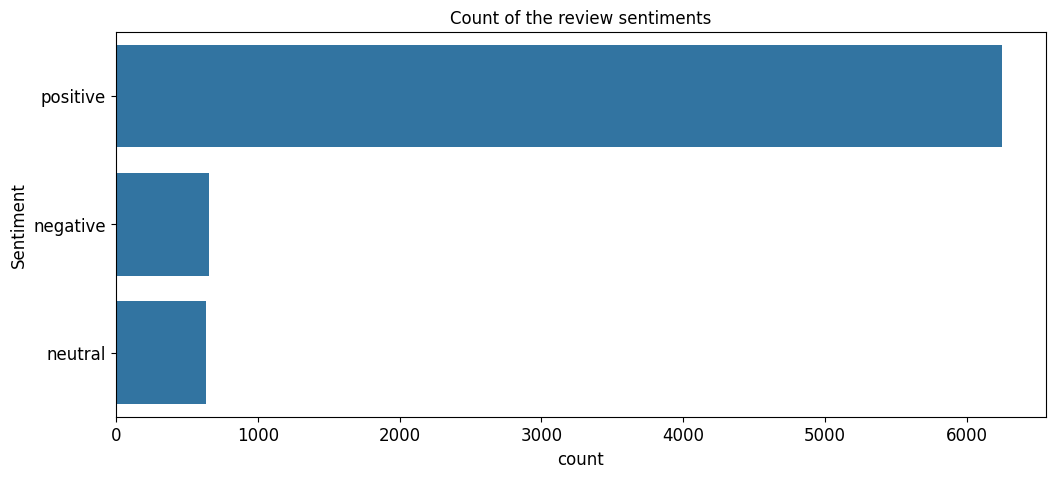

In [204]:
sns.countplot(reviews['Sentiment'])
plt.title('Count of the review sentiments')
plt.show()


- _The data seems to be fairly balanced. However, the objective of this project is to do topic modeling and not sentiment classification_

In [205]:
#check randomly any of the reviews
random = np.random.randint(1,len(reviews))
print(reviews['Review'][random])

not much say didnt come cool dodecabox performs exactly benchmark expected


In [206]:


# Get unique products from the 'product' column
unique_products = reviews['Product'].unique()

# Print the list of unique products
print("List of different types of products:")
for product in unique_products:
    print(product)


List of different types of products:
intel-i7-14700k
intel-i5-14600k
intel-i9-14900k
intel-i3-13100
intel-i5-13400
intel-i5-13500
intel-i5-13600k
intel-i7-13700k
intel-i9-13900k
intel-i5-12400f
intel-i3-12100f
intel-i5-12600k
intel-i7-12700k
intel-i9-12900k
intel-i5-11600k
intel-i7-11700k
intel-i9-11900k
intel-i3-10100
intel-i5-10400
intel-i5-10600k
intel-i7-10700k
intel-i9-10900k
nan


In [207]:
reviews.dropna(subset=['Product'], inplace=True)


In [208]:
len(reviews)

7528

## _Text Preprocessing_
_Following steps will be performed_
- _Tokenization - Split the text into sentences and sentences into words. Lowercase the words and remove any punctuation_
- _Words that are fewer than 3 characters will be removed_
- _All stopwords will be removed_
- _Words are lemmatized - words in third person are changed to first person and words in future and past tense are changed to present tense_
- _Words are stemmed - words are reduced to the root form_

In [209]:
#load the gensim library
import gensim

In [210]:
'''
Write a function to proprocess the entire dataset 
'''
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    '''This function will lemmatize on Noun POS and stem the text'''
    # return stemmer.stem(WordNetLemmatizer().lemmatize(text,pos='n'))
    return (WordNetLemmatizer().lemmatize(text,pos='n'))

#tokenize and lemmatize
def preprocess(text):
    '''Function to break into word tokens, remove stopwords, remove short words and finally to lemmatize and stem the individual tokens'''
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [211]:
#check for a sample review
result = preprocess('The worst camera I have ever seen. Even my very old configuration mobile phone had a better camera resolution. Battery draining faster.')
print(result)

['worst', 'camera', 'seen', 'configuration', 'mobile', 'phone', 'better', 'camera', 'resolution', 'battery', 'draining', 'faster']


In [212]:
processed_docs = []

#uncomment below line to find the topics for a particular sentiment
#reviews = reviews[reviews['sentiment']==1]

for doc in reviews['Review']:
    processed_docs.append(preprocess(doc))

In [165]:
'''
Preview the processed documents
'''
print(processed_docs[:10])

[['good', 'monster', 'nicely', 'boost', 'clock', 'core', 'core', 'unlimited', 'setting', 'thermally', 'limited', 'offset', 'noticed', 'cooler', 'previous', 'especially', 'consider', 'core', 'core', 'delta', 'gaming', 'encoding', 'long', 'great', 'case', 'plenty', 'flow', 'notch', 'cooler', 'easily', 'cooled', 'issue', 'throttle', 'thermal', 'maximum', 'uefi', 'biosin', 'gaming', 'workload', 'throttle', 'stay', 'core', 'boost', 'entire', 'time', 'temp', 'intensive', 'game', 'upper', 'upper', 'intensive', 'gamesupdatei', 'disabled', 'offset', 'working', 'like', 'charm', 'stable', 'gaming', 'workload', 'encoding', 'downclocks', 'encoding', 'workload', 'gaming', 'stay', 'amazing', 'cooled', 'setup', 'setup', 'optimal', 'cooling', 'temp', 'little', 'lower', 'running', 'enabled', 'offset', 'offset', 'enabled', 'crash', 'disabling', 'definitely', 'enables', 'powerif', 'youre', 'predominantly', 'machine', 'gaming', 'definitely', 'recommend', 'turning', 'regardless', 'game', 'tend', 'better', '

## _Bag of Words on the Dataset_

In [166]:
'''
Create a dictionary of the words which appear in the entire corpus
'''
dictionary = gensim.corpora.Dictionary(processed_docs)

In [167]:
dictionary.keys()[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [168]:
#print a few words in the dictionary
count = 0
for k,v in dictionary.iteritems():
    print(k,v)
    count = count + 1
    if count > 10:
        break

0 amazing
1 better
2 biosin
3 blend
4 boost
5 bump
6 case
7 charm
8 clock
9 consider
10 controller


### _Gensim filter extremes_
- _Remove or filter the words that appear less than nobelow_
- _Remove or filter the words that apepar more than noabove (fraction)_
- _After the above two steps keep only the n most frequent tokens or keep all_

In [169]:
dictionary.filter_extremes(no_below=5,no_above=0.1,keep_n=None)

### _Gensim doc2bow_
- _Create a bag of words for each document ie for each document we create a dictionary reporting how many words and how many times those words appear_

In [170]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [171]:
bow_corpus[10:20]

[[(10, 1),
  (12, 1),
  (32, 1),
  (39, 1),
  (40, 2),
  (51, 3),
  (55, 1),
  (56, 1),
  (62, 2),
  (71, 3),
  (87, 1),
  (91, 1),
  (95, 1),
  (104, 1),
  (107, 1),
  (115, 1),
  (118, 2),
  (159, 1),
  (207, 1),
  (218, 1),
  (244, 1),
  (288, 1),
  (311, 1),
  (321, 1),
  (323, 1),
  (327, 1),
  (328, 1),
  (335, 1),
  (358, 1),
  (377, 1),
  (424, 1),
  (440, 1),
  (449, 1),
  (478, 1),
  (481, 1),
  (509, 1),
  (538, 1),
  (539, 1),
  (540, 1),
  (541, 2),
  (542, 1),
  (543, 1),
  (544, 1),
  (545, 1),
  (546, 1),
  (547, 1),
  (548, 1),
  (549, 1),
  (550, 1),
  (551, 1),
  (552, 1),
  (553, 1),
  (554, 1),
  (555, 1),
  (556, 1),
  (557, 1),
  (558, 1)],
 [(2, 1),
  (12, 2),
  (23, 1),
  (26, 1),
  (29, 1),
  (30, 2),
  (35, 1),
  (47, 1),
  (52, 1),
  (53, 1),
  (62, 2),
  (65, 3),
  (75, 1),
  (81, 1),
  (90, 1),
  (97, 2),
  (102, 2),
  (104, 2),
  (105, 2),
  (117, 2),
  (120, 1),
  (141, 1),
  (148, 4),
  (151, 1),
  (179, 1),
  (187, 1),
  (198, 1),
  (202, 1),
  (205, 1

In [172]:
document_num = random
bow_doc_x = bow_corpus[random]

for i in range(len(bow_doc_x)):
    print(f'Word {bow_doc_x[i][0]} {dictionary[bow_doc_x[i][0]]} appears {bow_doc_x[i][1]} times')

Word 162 havent appears 1 times
Word 267 look appears 1 times
Word 471 looking appears 1 times
Word 773 installed appears 1 times
Word 1234 forward appears 1 times


## _Running LDA using Bag of Words_

In [173]:
#apply the gensim LDA model and generate 12 topics from the corpus
seed = 41
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,num_topics=15,id2word=dictionary,passes=10,workers=2,
                                      random_state=seed,minimum_probability=0.05,alpha='symmetric')

In [174]:
'''
For each topic, explore each word and its relative weight in the topic
'''

for idx,topic in lda_model.print_topics(-1,num_words=15):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")
    

Topic: 0 
Words: 0.068*"excellent" + 0.046*"love" + 0.029*"build" + 0.028*"core" + 0.013*"chip" + 0.013*"bought" + 0.012*"year" + 0.012*"service" + 0.011*"best" + 0.010*"high" + 0.010*"medium" + 0.010*"product" + 0.008*"delivery" + 0.008*"paired" + 0.008*"thank"


Topic: 1 
Words: 0.033*"cooler" + 0.032*"super" + 0.023*"temp" + 0.015*"thermal" + 0.014*"need" + 0.011*"best" + 0.011*"perfect" + 0.011*"working" + 0.010*"dont" + 0.009*"bought" + 0.009*"paste" + 0.008*"sure" + 0.008*"high" + 0.008*"case" + 0.008*"came"


Topic: 2 
Words: 0.019*"core" + 0.017*"cooler" + 0.016*"running" + 0.013*"chip" + 0.012*"thing" + 0.011*"asus" + 0.010*"temp" + 0.009*"like" + 0.009*"cool" + 0.008*"thermal" + 0.008*"recommend" + 0.008*"time" + 0.008*"handle" + 0.008*"upgrade" + 0.007*"need"


Topic: 3 
Words: 0.028*"issue" + 0.013*"havent" + 0.011*"task" + 0.011*"looking" + 0.011*"recommend" + 0.010*"best" + 0.010*"need" + 0.010*"youre" + 0.010*"powerful" + 0.010*"experience" + 0.009*"motherboard" + 0.009*

In [175]:
#import Coherence model from gensim
from gensim.models import CoherenceModel
#compute coherence score
lda_model_coherence = CoherenceModel(model=lda_model,texts=processed_docs,dictionary=dictionary,
                                    coherence='c_v')
coherence_lda = lda_model_coherence.get_coherence()
print('\nCoherence Score:',coherence_lda)


Coherence Score: 0.4756280821575788


## _Hyperparameter Tuning_
- _Number of topics K_
- _Dirichlet hyperparamater alpha: Document Topic Density_
- _Dirichlet hyperparameter beta: Word-Topic Density_

In [183]:
#define a helper function
def compute_coherence_score(corpus,dictionary,k,a):
    #instantiate the model instance based on k,a and b
    lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=dictionary,num_topics=k,alpha=a,
                                           passes=10,
                                           random_state=seed)
    lda_model_coherence = CoherenceModel(model=lda_model,texts=processed_docs,dictionary=dictionary,coherence='c_v')
    return lda_model_coherence.get_coherence()
    

In [184]:
#search for the best alpha and the number of topics --> one with the highest coherence score will be the best hyperparameter
alpha =['symmetric','asymmetric']

for x in alpha:
    print('Coherence Model with alpha = {}'.format(x))
    print('-------------------------------------------')
    print('\n')
    for i in range(5,10):
        score = compute_coherence_score(corpus=bow_corpus,dictionary=dictionary,k=i,a=x)        
        print(f'Coherence score with {i} topics is {score}')
        print('\n')
        # Track the best parameters
        if coherence_score > best_score:
            best_score = coherence_score
            best_params = (num_topics, alpha)

print(f'Best coherence score {best_score} achieved with parameters: {best_params}')

Coherence Model with alpha = symmetric
-------------------------------------------


Coherence score with 5 topics is 0.4804706303543241


Coherence score with 6 topics is 0.46877781038851096


Coherence score with 7 topics is 0.47917307218872857


Coherence score with 8 topics is 0.49876342642780924


Coherence score with 9 topics is 0.48643662750761035


Coherence Model with alpha = asymmetric
-------------------------------------------


Coherence score with 5 topics is 0.5513999650451146


Coherence score with 6 topics is 0.5453464237764908


Coherence score with 7 topics is 0.5717656059229279


Coherence score with 8 topics is 0.5352666984198036


Coherence score with 9 topics is 0.5198061255629303


Best coherence score 0.5522352653688475 achieved with parameters: (5, 'asymmetric')


In [185]:
'''
Though the model with alpha='asymmetric' and with 12 topics returned the highest coherence score. For the business use and simplicity, max topics of 7
and alpha='asymmetric' as the final model. This also returned a comparable coherence score of 0.6262
'''
lda_model_final = gensim.models.LdaMulticore(corpus=bow_corpus,num_topics=7,id2word=dictionary,passes=10,workers=2,alpha='asymmetric')

In [186]:
from pprint import pprint
# Print the Keyword in the 7 topics
pprint(lda_model_final.print_topics())
doc_lda = lda_model_final[bow_corpus]

[(0,
  '0.032*"product" + 0.024*"recommend" + 0.019*"excellent" + 0.014*"perfect" + '
  '0.013*"time" + 0.012*"value" + 0.011*"build" + 0.010*"chip" + 0.009*"core" '
  '+ 0.009*"better"'),
 (1,
  '0.044*"best" + 0.023*"easy" + 0.021*"cooler" + 0.020*"love" + '
  '0.015*"install" + 0.015*"amazing" + 0.015*"super" + 0.012*"thing" + '
  '0.012*"build" + 0.011*"sure"'),
 (2,
  '0.017*"worth" + 0.016*"year" + 0.016*"video" + 0.014*"like" + 0.012*"time" '
  '+ 0.012*"core" + 0.012*"build" + 0.011*"upgrade" + 0.010*"better" + '
  '0.009*"editing"'),
 (3,
  '0.025*"issue" + 0.019*"core" + 0.016*"upgrade" + 0.016*"motherboard" + '
  '0.011*"like" + 0.010*"havent" + 0.010*"running" + 0.010*"bought" + '
  '0.009*"pcie" + 0.009*"series"'),
 (4,
  '0.022*"core" + 0.019*"running" + 0.018*"cooler" + 0.017*"graphic" + '
  '0.011*"chip" + 0.011*"thing" + 0.010*"cooling" + 0.008*"load" + '
  '0.008*"temp" + 0.008*"dont"'),
 (5,
  '0.032*"core" + 0.023*"power" + 0.015*"cooling" + 0.015*"cooler" + '
  '0.

## _Topic Classification_


#### Topic 0: Positive Product Performance on a Budget
Products in this category are highly recommended for their excellent performance and value, making them perfect choices for budget-conscious buyers.

#### Topic 1: Issues with Battery and Hardware Upgrades
Users are experiencing issues with hardware upgrades, such as core and motherboard upgrades, which haven't been running smoothly since purchase.

#### Topic 2: Dissatisfaction with Sound and Video Quality
Over the years, users have found the video quality lacking, which makes it worth considering an upgrade for better editing capabilities.

#### Topic 3: Early Reliability Concerns
Since purchase, there have been reliability issues with devices running hotter than expected, which could be attributed to cooling and graphic chip problems.

#### Topic 4: Connectivity Challenges
Core power issues, along with cooling and temperature management, need to be addressed to ensure better connectivity and performance.

#### Topic 5: Poor Customer Service Experiences
Amazon and other platforms are known for their poor thermal control and high levels of dissatisfaction, especially when it comes to handling returns and replacements.

#### Topic 6: Quality and Reliability Issues
Core running and cooling performance issues, as well as graphic chip concerns, have led to frequent device freezes and load temperature spikes.



In [213]:
# Function to process each product and store its topics (with sentiment filtering)
def process_products_with_sentiment(reviews):
    for product in reviews['Product'].unique():
        print(f"Processing reviews for product: {product}")

        # Filter reviews for the current product and sentiment
        product_reviews = reviews[(reviews['Product'] == product) & (reviews['Sentiment'].isin(['negative', 'neutral']))]['Review']

        # Preprocess reviews for the current product (replace with your preprocessing logic)
        processed_docs = [preprocess(review) for review in product_reviews]
        
        # Print first 10 processed documents for the current product
        print(processed_docs[:10])
        print("\n")

        # Create dictionary and filter extremes
        dictionary = gensim.corpora.Dictionary(processed_docs)
        # dictionary.filter_extremes(no_below=5, no_above=0.1, keep_n=None)

        # Check if there are terms in the dictionary
        if len(dictionary) == 0:
            print(f"No terms left after filtering extremes for product: {product}. Skipping LDA computation.")
            continue

        # Create bag of words corpus
        bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

        # Check if corpus is empty
        if not bow_corpus:
            print(f"No valid data for product: {product}. Skipping LDA computation.")
            continue

        # Hyperparameter tuning: Search for the best alpha and number of topics
        alpha = ['symmetric', 'asymmetric']
        best_coherence_score = -1
        best_num_topics = -1
        best_alpha = None

        for a in alpha:
            print(f'Coherence Model with alpha = {a}')
            print('-------------------------------------------')
            print('\n')

            for k in range(5, 10):
                score = compute_coherence_score(corpus=bow_corpus, dictionary=dictionary, k=k, a=a)
                print(f'Coherence score with {k} topics is {score}')
                print('\n')

                # Track the best hyperparameters based on coherence score
                if score > best_coherence_score:
                    best_coherence_score = score
                    best_num_topics = k
                    best_alpha = a

        print(f"Best hyperparameters - Num Topics: {best_num_topics}, Alpha: {best_alpha}")
        print("\n")

        # Final LDA model with best hyperparameters
        lda_model_final = LdaMulticore(corpus=bow_corpus, num_topics=best_num_topics, id2word=dictionary,
                                       passes=10, workers=2, alpha=best_alpha, random_state=41)

        # Store topics for the current product in product_topics dictionary (assuming it's defined elsewhere)
        topics = lda_model_final.print_topics(num_words=15)  # Adjust num_words as needed
        product_topics[product] = topics

        # Print the topics of the final LDA model
        pprint(lda_model_final.print_topics())
        doc_lda = lda_model_final[bow_corpus]
    
        # Print the document-topic distribution for each product
        pprint(lda_model_final.print_topics())
        doc_lda = lda_model_final[bow_corpus]

# Example usage: Process products and then print topics for specific products
process_products_with_sentiment(reviews)


Processing reviews for product: intel-i7-14700k
[['built', 'series', 'stability', 'problem', 'researching', 'week', 'reinstalling', 'better', 'result', 'finally', 'disabled', 'overclocking', 'overclocking', 'running', 'high', 'bios', 'setting', 'running', 'tool', 'intel', 'fail', 'safe', 'allowed', 'stress', 'test', 'successfully', 'basically', 'throttle', 'chipi', 'tell', 'frustration', 'caused', 'figuring', 'chrome', 'browser', 'adobe', 'crash', 'randomly', 'apparent', 'reason', 'minute', 'test', 'showed', 'fine', 'lowered', 'refresh', 'rate', 'killed', 'overclocking', 'intel', 'setting', 'stable', 'outperforms', 'encoding', 'impressive', 'water', 'cooling', 'avoid', 'chip', 'oodle', 'issue', 'come', 'gaming', 'unreal', 'basically', 'unfixable', 'hardware', 'flaw', 'affect', 'chipsheres', 'thing', 'notice', 'difference', 'exception', 'handbrake', 'come', 'close', 'maxing', 'chip', 'adobe', 'intel', 'quicksync', 'igpu', 'simultaneously', 'rarely', 'went', 'usually', 'editing', 'encode

In [214]:
# Function to print topics for a specific product
def print_topics_for_product(product_name):
    if product_name in product_topics:
        print(f"Topics for product: {product_name}")
        print()
        topics = product_topics[product_name]
        for topic_id, topic_words in topics:
            print(f"Topic {topic_id}: {topic_words}")
            print()  # This adds a blank line after each topic
        print()  # This adds a blank line after all topics
    else:
        print(f"No topics found for product: {product_name}")


In [282]:
# Example usage: Print topics for a specific product
print_topics_for_product('intel-i7-14700k')

Topics for product: intel-i7-14700k

Topic 0: 0.023*"processor" + 0.015*"intel" + 0.015*"running" + 0.011*"gaming" + 0.011*"fast" + 0.011*"core" + 0.011*"upgraded" + 0.011*"upgrade" + 0.011*"need" + 0.011*"good" + 0.011*"damaged" + 0.011*"voltage" + 0.008*"looking" + 0.008*"issue" + 0.008*"fortnite"

Topic 1: 0.042*"performance" + 0.023*"work" + 0.023*"core" + 0.023*"cooler" + 0.023*"fast" + 0.015*"dont" + 0.015*"price" + 0.015*"gaming" + 0.015*"bought" + 0.015*"cheaper" + 0.015*"liked" + 0.015*"wasnt" + 0.015*"advertised" + 0.015*"instead" + 0.015*"refund"

Topic 2: 0.031*"core" + 0.018*"thing" + 0.014*"power" + 0.014*"heat" + 0.014*"policy" + 0.012*"problem" + 0.011*"bios" + 0.010*"intel" + 0.010*"setting" + 0.010*"killed" + 0.009*"crashing" + 0.009*"supply" + 0.009*"card" + 0.009*"graphic" + 0.009*"constant"

Topic 3: 0.002*"running" + 0.002*"overclocking" + 0.002*"processor" + 0.002*"adobe" + 0.002*"intel" + 0.002*"water" + 0.002*"stable" + 0.002*"chip" + 0.002*"gaming" + 0.002*"vo


#### Topic 0: Processor Performance and Upgrades

**Problem**: Issues with Intel processors running too fast, leading to overheating and potential damage. Dissatisfaction with upgrade improvements in performance.

**Recommendation**: Provide clear guidelines on optimal processor speeds to prevent overheating. Enhance processor cooling solutions or recommend appropriate cooling upgrades alongside processor purchases. Offer detailed performance benchmarks and upgrade paths to manage customer expectations effectively.

---

#### Topic 1: System Performance and Price

**Problem**: Dissatisfaction with system performance and cooler efficiency, products often deemed overpriced for delivered performance. Issues with products not meeting advertised specifications.

**Recommendation**: Review pricing strategies to align with performance delivered. Implement rigorous quality control to ensure products meet advertised specifications before shipping. Offer transparent performance benchmarks and comparisons to justify pricing and boost customer confidence.

---

#### Topic 2: Core Issues and System Stability

**Problem**: Core utilization issues, system instability related to power consumption, heat management, BIOS settings, and frequent crashes during intensive tasks.

**Recommendation**: Enhance BIOS updates to optimize core utilization and system stability. Provide detailed troubleshooting guides for managing power consumption and heat issues. Conduct rigorous stability testing to address crash concerns under varying workloads.

---

#### Topic 3: Overclocking and Gaming Stability

**Problem**: Stability issues during overclocking, instability in Adobe applications, and challenges in maintaining stable gaming performance.

**Recommendation**: Offer user-friendly overclocking tools with built-in stability checks and stress tests. Provide tutorials and educational resources on optimizing system settings for Adobe applications and gaming. Collaborate with users to gather feedback and improve stability under overclocked conditions.

---

#### Topic 4: Motherboard and Cooling Solutions

**Problem**: Issues with motherboard compatibility, inadequate cooling performance, problems with graphic cards despite recommended solutions.

**Recommendation**: Provide compatibility lists and ensure clear communication on motherboard requirements for processors and graphic cards. Improve cooling solution recommendations based on specific hardware configurations. Offer user-friendly installation guides and troubleshooting support for cooling-related issues.

---

#### Topic 5: Cooling Standards and Generation Differences

**Problem**: Concerns about cooling standards across processor generations, significant differences in cooling capabilities with advanced solutions like water cooling.

**Recommendation**: Standardize cooling recommendations across processor generations to manage customer expectations consistently. Provide educational resources on the benefits of advanced cooling solutions like water cooling and their application in managing processor heat. Offer bundled packages for processor upgrades with recommended cooling solutions.

---

#### Topic 6: Installation and Order Processing

**Problem**: Difficulties during installation, slow order processing times, issues with faulty products and BIOS updates.

**Recommendation**: Streamline the installation process with intuitive guides and troubleshooting resources. Improve order processing times and communication on order status updates. Enhance quality control measures to minimize faulty product shipments. Implement proactive customer support to address BIOS update delays and other technical issues promptly.

---

#### Topic 7: Intel Chip Features and Testing

**Problem**: Criticism of Intel chip features affecting Adobe software performance, frustration with stability testing and BIOS settings.

**Recommendation**: Collaborate with Adobe and software developers to optimize chip features for improved performance. Enhance stability testing protocols to simulate real-world usage scenarios. Provide comprehensive BIOS customization guides to enable users to optimize chip features based on their specific needs.

---

#### Topic 8: Performance Needs and Cooler Requirements

**Problem**: Varied performance needs, importance of efficient cooling solutions to manage voltage and avoid overheating. Concerns about advertised versus actual performance.

**Recommendation**: Offer tailored cooling solutions based on processor specifications and customer performance requirements. Provide detailed performance metrics and benchmarks to accurately depict processor capabilities. Collaborate with users to understand thread management needs and optimize performance accordingly.


In [283]:
print_topics_for_product('intel-i5-14600k')

Topics for product: intel-i5-14600k

Topic 0: 0.018*"intel" + 0.016*"core" + 0.016*"running" + 0.011*"gaming" + 0.011*"processor" + 0.011*"bios" + 0.011*"overclocking" + 0.008*"cooler" + 0.008*"issue" + 0.008*"water" + 0.008*"power" + 0.008*"damaged" + 0.008*"dont" + 0.008*"need" + 0.008*"setting"

Topic 1: 0.040*"motherboard" + 0.026*"performance" + 0.026*"getting" + 0.017*"intel" + 0.017*"cooling" + 0.017*"recommend" + 0.017*"work" + 0.017*"saying" + 0.017*"paid" + 0.017*"extreme" + 0.017*"sure" + 0.013*"ordered" + 0.009*"asus" + 0.009*"crash" + 0.009*"refund"

Topic 2: 0.048*"processor" + 0.025*"cooler" + 0.025*"game" + 0.013*"water" + 0.013*"stay" + 0.013*"processing" + 0.013*"codejust" + 0.013*"problem" + 0.013*"editing" + 0.013*"playing" + 0.013*"destroys" + 0.013*"brush" + 0.013*"reveals" + 0.013*"remember" + 0.013*"bios"

Topic 3: 0.003*"upgrade" + 0.003*"processor" + 0.003*"intel" + 0.003*"money" + 0.003*"reliability" + 0.003*"leader" + 0.003*"locking" + 0.003*"artificial" + 0


#### Topic 0: Intel Processor and Gaming Issues

**Problem**: Concerns about Intel processors running at high speeds during gaming, leading to overheating and BIOS-related issues. Complaints about overclocking challenges and inadequate cooler performance.

**Recommendation**: Provide clear guidelines on optimal processor speeds and cooling solutions to prevent overheating during gaming sessions. Enhance BIOS updates to optimize performance and stability under varying gaming loads. Offer bundled packages that include suitable cooling solutions for customers purchasing processors aimed at gaming.

---

#### Topic 1: Motherboard Performance and Customer Satisfaction

**Problem**: Mixed experiences with motherboard performance, including issues with cooling efficiency and system stability. Frustrations with product recommendations and refund processes.

**Recommendation**: Improve transparency in product recommendations based on specific customer needs and hardware configurations. Enhance cooling solutions compatibility and provide clearer communication on motherboard specifications to ensure customer satisfaction. Streamline the refund process with quicker responses and resolutions for faulty products.

---

#### Topic 2: Processor Performance and Gaming Experience

**Problem**: Issues with gaming performance on Intel processors, concerns about processor cooling, and BIOS settings affecting gaming experience. Complaints about system stability during gaming sessions.

**Recommendation**: Optimize BIOS settings and cooling solutions tailored for gaming scenarios. Offer educational resources on optimizing system settings for enhanced gaming performance. Provide regular updates and patches to address stability issues reported during gaming sessions.

---

#### Topic 3: Processor Upgrades and Reliability Concerns

**Problem**: Considerations for upgrading Intel processors, including concerns about reliability, performance expectations, and market trends. Issues related to processor reliability and user experiences.

**Recommendation**: Provide detailed product comparisons and benchmarks for prospective upgrades to manage customer expectations. Implement rigorous quality control measures to ensure reliability in newly released processors. Gather user feedback to continuously improve processor performance and reliability based on real-world usage scenarios.

---

#### Topic 4: Core and System Stability

**Problem**: Concerns about core utilization, system stability issues related to voltage, power supply, and graphic card performance. Reports of system crashing and inconsistent performance.

**Recommendation**: Enhance stability testing protocols to simulate real-world scenarios and ensure consistent performance across varying workloads. Offer troubleshooting guides and customer support for resolving system stability issues related to core utilization and power management. Collaborate with graphic card manufacturers to optimize performance compatibility with Intel processors.

---

#### Topic 5: Cooling Solutions and Generation Differences

**Problem**: Discussions on cooling solutions across different generations of Intel processors, highlighting differences in cooling capabilities and system performance. Issues related to cooler effectiveness and system cooling management.

**Recommendation**: Standardize cooling recommendations across processor generations to ensure compatibility and effectiveness. Provide educational resources on selecting and installing appropriate cooling solutions based on processor specifications. Conduct regular updates and improvements to cooling solutions to enhance overall system performance and longevity.

---

#### Topic 6: Processor Cooling and Thermal Management

**Problem**: Focus on thermal management and cooling solutions for Intel processors, including discussions on cooler performance, thermal paste application, and benchmarking results under stress.

**Recommendation**: Offer best practices guides on thermal paste application and maintenance for optimal cooler performance. Provide benchmarks and real-world performance data to illustrate the effectiveness of cooling solutions under stress conditions. Collaborate with cooling solution providers to innovate and develop more efficient cooling solutions tailored for Intel processors.

---

#### Topic 7: Cooling Standards and System Configuration

**Problem**: Discussions on cooling standards and system configuration preferences, emphasizing differences in cooling solutions and processor performance. Issues related to system configuration and cooling efficiency.

**Recommendation**: Develop customizable cooling solutions that cater to various system configurations and user preferences. Offer modular cooling systems that can be adjusted based on specific processor and system requirements. Provide customer support and resources for optimizing system configuration to maximize cooling efficiency and processor performance.

---

#### Topic 8: Processor Performance and Gaming Requirements

**Problem**: Discussions on processor performance requirements for gaming, emphasizing the need for efficient cooling solutions and adequate system performance. Issues related to gaming performance and system requirements.

**Recommendation**: Develop gaming-centric processors with enhanced cooling solutions integrated into the design. Offer customizable gaming bundles that include optimized processors and cooling solutions tailored for gaming requirements. Provide regular updates and patches to address performance bottlenecks reported by gamers and ensure smooth gameplay experiences.

---



In [284]:
print_topics_for_product('intel-i9-14900k')

Topics for product: intel-i9-14900k

Topic 0: 0.023*"intel" + 0.015*"core" + 0.015*"processor" + 0.015*"issue" + 0.012*"dont" + 0.012*"generation" + 0.012*"looking" + 0.012*"product" + 0.012*"upgrade" + 0.008*"running" + 0.008*"gaming" + 0.008*"heat" + 0.008*"thread" + 0.008*"power" + 0.008*"time"

Topic 1: 0.030*"motherboard" + 0.022*"cooler" + 0.019*"fast" + 0.019*"case" + 0.015*"need" + 0.015*"cooling" + 0.011*"year" + 0.011*"didnt" + 0.011*"speed" + 0.011*"water" + 0.011*"worst" + 0.011*"difference" + 0.008*"purchased" + 0.008*"sure" + 0.008*"temp"

Topic 2: 0.017*"chip" + 0.017*"mainboard" + 0.017*"thousand" + 0.012*"ordered" + 0.012*"fault" + 0.012*"didnt" + 0.012*"asus" + 0.012*"intel" + 0.012*"soooo" + 0.012*"hate" + 0.012*"issue" + 0.006*"course" + 0.006*"refunding" + 0.006*"ended" + 0.006*"highly"

Topic 3: 0.020*"voltage" + 0.020*"running" + 0.014*"thing" + 0.014*"good" + 0.014*"need" + 0.014*"want" + 0.014*"damaged" + 0.014*"gaming" + 0.007*"cooler" + 0.007*"delid" + 0.007*


#### Topic 0: Intel Processor Issues and Upgrades

**Problem**: Concerns about Intel processor issues including generation upgrades, heat management during gaming, and power requirements. Issues with performance and considerations for upgrades.

**Recommendation**: Provide clearer guidance on generation upgrades and their implications for heat management and power consumption, especially for gaming setups. Offer educational resources on optimizing processor performance to maximize efficiency and longevity. Improve communication on upgrade paths and compatibility to manage customer expectations.

---

#### Topic 1: Motherboard and Cooling Performance

**Problem**: Focus on motherboard and cooling performance, including experiences with cooling solutions, case compatibility, and user satisfaction with cooling effectiveness. Issues with temperature management and product expectations.

**Recommendation**: Enhance compatibility guides for cooling solutions and motherboard configurations to ensure seamless integration and optimal performance. Develop standardized cooling solutions that cater to different case sizes and user preferences. Improve transparency in product specifications and performance metrics to align customer expectations with product capabilities.

---

#### Topic 2: Asus Motherboard Issues

**Problem**: Frustrations with Asus motherboard issues, including delivery faults, refund processes, and dissatisfaction with customer service. Specific problems with ordering and negative experiences with the product.

**Recommendation**: Strengthen quality control measures to minimize delivery faults and product defects. Improve customer service response times and transparency in refund processes to enhance customer satisfaction. Implement user-friendly troubleshooting guides and support resources to address common issues reported with Asus motherboards.

---

#### Topic 3: Voltage and Gaming Performance

**Problem**: Discussions on voltage requirements for gaming, concerns about system damage, specially tailored setups, and core performance under stress. Specific needs related to gaming performance and adjustments.

**Recommendation**: Offer comprehensive guidelines on voltage settings and system configurations for optimal gaming performance without compromising system stability. Develop educational content on safe overclocking practices and voltage management to prevent potential damage to processors and other components. Provide tools or software utilities to simplify voltage adjustments and monitor system performance during gaming sessions.

---

#### Topic 4: Intel Performance and Customer Satisfaction

**Problem**: Mixed experiences with Intel performance, including issues with system crashes, paid services, and overall satisfaction with motherboard capabilities. Concerns about performance-related issues and product recalls.

**Recommendation**: Implement proactive measures to address reported issues with system crashes and performance inconsistencies. Enhance customer support channels for quicker resolution of technical issues and product recalls. Conduct regular updates and optimizations to improve Intel processor performance and reliability based on customer feedback and real-world usage scenarios.

---

#### Topic 5: Overclocking and Processor Performance

**Problem**: Experiences with overclocking Intel processors, including settings for Adobe software, water cooling efficiency, and processor stability. Discussions on gaming performance and system setups.

**Recommendation**: Provide advanced overclocking tools and software utilities tailored for Intel processors to optimize performance for both gaming and professional applications like Adobe software. Offer tutorials and community forums for sharing best practices and troubleshooting overclocking issues. Collaborate with cooling solution providers to develop efficient water cooling solutions that enhance processor stability and longevity under overclocked conditions.

---

#### Topic 6: Power Supply and Processor Settings

**Problem**: Discussions on power supply configurations, processor settings including default configurations, downclocking options, and adjustments for graphic card compatibility. Experiences with BIOS settings and system power management.

**Recommendation**: Develop comprehensive power supply compatibility guides to assist users in selecting suitable configurations for Intel processors and graphic cards. Simplify BIOS settings for easier navigation and adjustment of processor settings. Provide educational resources on power management strategies to optimize energy efficiency and system performance. Collaborate with power supply manufacturers to ensure compatibility and reliability in diverse system configurations.

---

#### Topic 7: Intel Chip and Overclocking

**Problem**: Discussions on Intel chip capabilities and overclocking experiences, including stability testing, performance adjustments for Adobe software, system settings, water cooling efficiency, and impressive system performance.

**Recommendation**: Enhance Intel chip capabilities through firmware updates and optimizations that improve overclocking potential and stability under varying workloads. Provide comprehensive overclocking guides tailored for Adobe software and other intensive applications. Collaborate with system integrators to showcase overclocked systems and their performance benefits, demonstrating reliability and efficiency in real-world scenarios.

---


In [285]:
print_topics_for_product('intel-i3-13100')

Topics for product: intel-i3-13100

Topic 0: 0.083*"price" + 0.083*"card" + 0.083*"cost" + 0.083*"expensive" + 0.083*"hindrance" + 0.083*"graphic" + 0.083*"performance" + 0.083*"working" + 0.083*"stably" + 0.008*"value" + 0.008*"surprised" + 0.008*"generation" + 0.008*"number" + 0.008*"comparable" + 0.008*"downgrade"

Topic 1: 0.072*"decent" + 0.072*"beast" + 0.072*"apps" + 0.072*"handle" + 0.072*"little" + 0.072*"core" + 0.072*"game" + 0.072*"throw" + 0.072*"provided" + 0.072*"modern" + 0.072*"value" + 0.007*"price" + 0.007*"stably" + 0.007*"working" + 0.007*"comparable"

Topic 2: 0.077*"year" + 0.077*"think" + 0.041*"broke" + 0.041*"downgrade" + 0.041*"choice" + 0.041*"number" + 0.041*"comparable" + 0.041*"generation" + 0.041*"surprised" + 0.040*"people" + 0.040*"reasonable" + 0.040*"probably" + 0.040*"need" + 0.040*"understand" + 0.040*"problem"

Topic 3: 0.026*"think" + 0.025*"year" + 0.025*"impression" + 0.025*"detail" + 0.025*"december" + 0.025*"price" + 0.025*"half" + 0.025*"rel



#### Topic 0: Graphics Card Performance and Pricing

**Problem**: Concerns about high costs of graphics cards impacting performance, affordability, and value for money.

**Recommendation**: Improve transparency in pricing strategies to align with market expectations and customer budgets. Offer tiered pricing options that cater to different performance needs without compromising quality. Enhance value propositions by emphasizing performance benchmarks and real-world applications in marketing materials to justify costs effectively.

---

#### Topic 1: Performance and Capability of Modern Apps

**Problem**: Discussions on how well graphics cards handle modern apps and games, emphasizing their performance and overall value.

**Recommendation**: Provide detailed performance metrics and compatibility guidelines for popular modern applications and games. Develop case studies or user testimonials that highlight the effective use of graphics cards in managing diverse tasks. Collaborate with software developers to optimize graphics card performance for specific applications and enhance user experience.

---

#### Topic 2: Longevity and Value Considerations

**Problem**: Customers evaluating the longevity and value of graphics cards over generational upgrades, comparing performance against previous models.

**Recommendation**: Introduce trade-in or upgrade programs that incentivize customers to exchange older models for newer ones at reduced costs. Conduct regular customer surveys to gather feedback on feature preferences and longevity expectations, informing future product developments and marketing strategies.

---

#### Topic 3: Pricing and Market Perception

**Problem**: Customer perceptions about pricing fairness, market positioning, and the perceived value of graphics cards compared to alternatives.

**Recommendation**: Conduct market research to assess competitive pricing strategies and adjust pricing accordingly to improve market positioning. Enhance customer education on the benefits of higher-priced models through detailed product comparisons and performance demonstrations. Utilize customer feedback loops to continuously refine pricing strategies based on market demand and competitive landscape.

---

#### Topic 4: Graphics Card Cost and Performance

**Problem**: Evaluations of cost-effectiveness and performance balancing with system stability, addressing performance issues, and consumer decision-making factors.

**Recommendation**: Develop educational content and tools that help users optimize system configurations for balanced performance and stability. Provide clear guidance on overclocking and cooling solutions to maximize performance without compromising system reliability. Offer transparent warranty and support policies to reassure customers about long-term investment value.

---

#### Topic 5: Graphics Card Value and Affordability

**Problem**: Assessments of graphics card value in relation to affordability, focusing on performance in gaming and computing tasks.

**Recommendation**: Introduce financing options or installment plans to make higher-end graphics cards more accessible to budget-conscious consumers. Enhance product bundling options with essential accessories or software to increase perceived value. Implement price-matching policies to remain competitive while ensuring customers receive the best value for their investment.

---

#### Topic 6: Value and Performance Assessment

**Problem**: Discussions on evaluating graphics card performance against price and user expectations, focusing on handling modern applications effectively.

**Recommendation**: Establish an online community or forum where users can share performance benchmarks and compare experiences with different graphics card models. Provide detailed product specifications and compatibility information to assist customers in making informed purchasing decisions. Offer personalized recommendations based on user preferences and usage scenarios to enhance satisfaction and value perception.

---

#### Topic 7: Modern Apps and Graphics Card Performance

**Problem**: Assessments of graphics card performance in managing modern applications and games effectively.

**Recommendation**: Collaborate with software developers to optimize graphics card drivers and compatibility with the latest applications and games. Provide regular updates and patches to address performance issues and enhance stability. Conduct usability studies to identify common user pain points and prioritize improvements that align with customer needs and expectations.

---

#### Topic 8: Graphics Card Capability and Market Value

**Problem**: Evaluations of graphics card capability and market value, including performance metrics and affordability considerations.

**Recommendation**: Enhance product differentiation through tiered product offerings that cater to varying customer needs and budgets. Develop marketing campaigns that emphasize the unique features and benefits of each graphics card model to target specific customer segments effectively. Monitor market trends and adjust product strategies accordingly to maintain competitiveness and maximize market share.

---


In [286]:
print_topics_for_product('intel-i5-13400')

Topics for product: intel-i5-13400

Topic 0: 0.035*"processor" + 0.024*"product" + 0.024*"cooler" + 0.024*"faulty" + 0.024*"week" + 0.012*"stock" + 0.012*"broken" + 0.012*"load" + 0.012*"good" + 0.012*"laminar" + 0.012*"ghzinstalled" + 0.012*"month" + 0.012*"usabledevice" + 0.012*"operating" + 0.012*"coretm"

Topic 1: 0.028*"working" + 0.028*"issue" + 0.028*"good" + 0.028*"speed" + 0.028*"processor" + 0.028*"stock" + 0.028*"game" + 0.028*"range" + 0.028*"exelent" + 0.028*"performs" + 0.028*"expected" + 0.028*"playing" + 0.028*"cooler" + 0.028*"broken" + 0.028*"returned"

Topic 2: 0.037*"processor" + 0.025*"temperature" + 0.025*"game" + 0.025*"heatsink" + 0.025*"wasnt" + 0.025*"tight" + 0.013*"change" + 0.013*"brutal" + 0.013*"intel" + 0.013*"industry" + 0.013*"despite" + 0.013*"consumption" + 0.013*"cooling" + 0.013*"replaced" + 0.013*"compared"

Topic 3: 0.057*"stably" + 0.057*"working" + 0.006*"value" + 0.006*"processor" + 0.006*"upgrade" + 0.006*"night" + 0.006*"good" + 0.006*"produ



#### Topic 0: Processor and Cooler Issues

**Problem**: Customers report issues with processors and coolers, including faulty products and operational difficulties.

**Recommendation**: Enhance quality control processes to minimize defects in processors and coolers. Provide clear troubleshooting guides and customer support channels for quick resolution of operational issues. Implement rigorous testing protocols to ensure products perform reliably under various loads and conditions.

---

#### Topic 1: Gaming Performance and Cooler Efficiency

**Problem**: Concerns about processor performance in gaming and the efficiency of cooling solutions.

**Recommendation**: Optimize cooling solutions to effectively manage processor temperatures during gaming sessions. Offer performance tuning guides and software utilities to maximize gaming performance without compromising system stability. Engage with gaming communities to gather feedback and continuously improve cooling solutions based on user experiences.

---

#### Topic 2: Processor Heat Management

**Problem**: Challenges in managing processor temperatures and comparing cooling efficiency.

**Recommendation**: Improve heat sink designs and thermal management solutions to enhance cooling efficiency. Provide educational resources on proper heat sink installation and thermal paste application for optimal performance. Conduct regular updates and enhancements to cooling solutions based on advancements in heat dissipation technology.

---

#### Topic 3: Stability and Performance Evaluation

**Problem**: Customers seek stable processor performance and evaluate product value.

**Recommendation**: Conduct comprehensive stability tests to ensure processors meet performance expectations under various workloads. Offer extended warranty options to instill confidence in product reliability. Collect customer feedback to understand performance expectations and iterate on product improvements accordingly.

---

#### Topic 4: Product Return and Service Issues

**Problem**: Issues with returning faulty products and the quality of service provided during repairs or replacements.

**Recommendation**: Streamline the return process with clear guidelines and user-friendly interfaces for initiating returns. Improve service turnaround times and communication during repair processes. Implement quality assurance measures to prevent recurring issues in repaired products.

---

#### Topic 5: User Experience with Ordered Products

**Problem**: User experiences with product accuracy and compatibility with operating systems like Linux.

**Recommendation**: Enhance product descriptions to accurately reflect specifications and compatibility details, especially for niche operating systems like Linux. Provide customer support resources tailored to Linux users for troubleshooting and compatibility issues. Establish partnerships with Linux communities to gather feedback and improve compatibility.

---

#### Topic 6: Graphics Card Performance and Cost

**Problem**: Concerns about the cost-effectiveness and performance of graphics cards.

**Recommendation**: Offer transparent pricing strategies that reflect performance benefits and market competitiveness. Provide performance benchmarks and comparison tools to help customers make informed purchasing decisions. Develop loyalty programs or bundle offers to enhance value propositions for customers upgrading from older generations.

---

#### Topic 7: Troubleshooting and Customer Support

**Problem**: Issues related to troubleshooting technical problems and customer support experiences.

**Recommendation**: Invest in comprehensive training for customer support teams to handle technical inquiries effectively. Implement robust online troubleshooting resources and community forums where customers can find solutions independently. Monitor customer feedback and satisfaction metrics to continuously improve support services.

---

#### Topic 8: Market Perception and Pricing

**Problem**: Perceptions of product pricing and value in the market.

**Recommendation**: Conduct market research to align pricing strategies with customer expectations and competitive benchmarks. Communicate product value through targeted marketing campaigns that highlight unique features and performance benefits. Regularly review pricing models based on market dynamics and customer feedback to maintain competitive pricing and perceived value.

---


In [287]:
print_topics_for_product('intel-i5-13500')

Topics for product: intel-i5-13500

Topic 0: 0.038*"power" + 0.029*"idle" + 0.020*"work" + 0.020*"product" + 0.020*"amazon" + 0.020*"expense" + 0.020*"good" + 0.020*"core" + 0.020*"ecore" + 0.020*"thread" + 0.020*"neck" + 0.020*"running" + 0.020*"server" + 0.020*"half" + 0.011*"need"

Topic 1: 0.036*"graphic" + 0.036*"value" + 0.036*"overclockable" + 0.036*"great" + 0.036*"waiting" + 0.036*"perfomance" + 0.036*"onboard" + 0.036*"insane" + 0.036*"wanted" + 0.036*"money" + 0.036*"upgrading" + 0.036*"sale" + 0.036*"finally" + 0.006*"work" + 0.006*"damage"

Topic 2: 0.010*"work" + 0.010*"damage" + 0.010*"need" + 0.010*"watt" + 0.010*"timely" + 0.010*"shipped" + 0.010*"drawing" + 0.010*"camera" + 0.010*"iris" + 0.010*"blue" + 0.010*"proxmox" + 0.010*"needgreat" + 0.010*"sever" + 0.010*"half" + 0.010*"priceit"

Topic 3: 0.049*"stress" + 0.049*"noctua" + 0.049*"temperature" + 0.049*"cooled" + 0.008*"work" + 0.008*"damage" + 0.008*"need" + 0.008*"drawing" + 0.008*"timely" + 0.008*"shipped" + 0



#### Topic 0: Power and Performance Management

**Problem**: Users express concerns about power management efficiency and performance reliability, particularly in server environments.

**Recommendation**: Enhance power management features to optimize idle power consumption and overall efficiency. Conduct rigorous reliability testing under varied workloads to ensure consistent performance in server setups. Provide educational resources on power optimization for users to maximize efficiency without compromising performance.

---

#### Topic 1: Graphics Card Upgrade and Value

**Problem**: Customers seek improved performance and value when upgrading graphics cards, weighing financial considerations and waiting for sales.

**Recommendation**: Offer transparent pricing and promotional strategies to facilitate cost-effective upgrades. Highlight overclockable options and their performance benefits to attract enthusiasts. Provide comparison tools and performance benchmarks to aid customers in making informed upgrade decisions.

---

#### Topic 2: Equipment and Server Maintenance

**Problem**: Issues related to equipment maintenance, including power wattage requirements, shipping timeliness, and equipment functionality for server setups.

**Recommendation**: Implement streamlined logistics and shipping processes to ensure timely delivery of server equipment. Provide comprehensive maintenance guides and support for setting up and maintaining server configurations. Offer scalable solutions that cater to varying power wattage requirements to meet diverse server needs.

---

#### Topic 3: Cooling Solutions and Temperature Management

**Problem**: Customers discuss cooling solutions for processors, emphasizing efficiency, stress testing results, and product reliability like Noctua coolers.

**Recommendation**: Develop advanced cooling solutions that prioritize efficiency and reliability under stress. Offer customizable cooling options to cater to different processor configurations and user preferences. Provide detailed stress testing results and user testimonials to build confidence in cooling performance and reliability.

---

#### Topic 4: Integrated Graphics and Gaming Performance

**Problem**: Users evaluate integrated graphics performance versus dedicated graphics cards like ASUS, focusing on gaming performance expectations and preferences.

**Recommendation**: Enhance integrated graphics capabilities through driver updates and optimization for popular gaming titles like Valorant. Provide clear performance differentials between integrated and dedicated graphics solutions to help users make informed choices based on their gaming needs. Offer user-friendly guides for optimizing gaming settings to achieve optimal performance with integrated graphics solutions.

---


In [288]:
print_topics_for_product('intel-i5-13600k')

Topics for product: intel-i5-13600k

Topic 0: 0.044*"work" + 0.033*"price" + 0.023*"performance" + 0.023*"memory" + 0.023*"illustrator" + 0.012*"heavy" + 0.012*"generation" + 0.012*"little" + 0.012*"thought" + 0.012*"temperature" + 0.012*"review" + 0.012*"know" + 0.012*"degree" + 0.012*"high" + 0.012*"reliably"

Topic 1: 0.022*"value" + 0.015*"year" + 0.015*"good" + 0.015*"processor" + 0.015*"paired" + 0.015*"skip" + 0.015*"going" + 0.015*"read" + 0.015*"couple" + 0.015*"mind" + 0.015*"card" + 0.015*"gpus" + 0.015*"pairing" + 0.015*"currently" + 0.015*"probably"

Topic 2: 0.022*"price" + 0.022*"processor" + 0.022*"expected" + 0.022*"beast" + 0.022*"reasonable" + 0.022*"extremely" + 0.022*"stepped" + 0.022*"ahoy" + 0.022*"graphic" + 0.022*"captain" + 0.022*"ultra" + 0.022*"stuck" + 0.022*"upgraded" + 0.022*"intel" + 0.002*"gray"

Topic 3: 0.057*"gaming" + 0.020*"frame" + 0.020*"extra" + 0.020*"absolutely" + 0.020*"rendering" + 0.020*"throw" + 0.010*"year" + 0.010*"didnt" + 0.010*"turn" 


#### Topic 0: Performance and Work Efficiency

**Problem**: Users emphasize performance for work-related tasks like Illustrator, considering price, memory usage, and thermal management.

**Recommendation**: Optimize processor performance for tasks like Illustrator through software updates and hardware optimizations. Provide clear pricing tiers and memory requirements for different tasks to guide user decisions. Enhance thermal management features to maintain performance under load.

---

#### Topic 1: GPU Performance and Future Upgrades

**Problem**: Customers seek value and performance longevity from GPUs, discussing pairing with processors, gaming performance, and future upgrade considerations.

**Recommendation**: Offer GPUs that balance performance and value, with a focus on longevity through driver updates and compatibility with evolving technology. Provide compatibility guides for pairing GPUs with processors to maximize performance. Highlight future upgrade paths and technological advancements to inform purchasing decisions.

---

#### Topic 2: Intel Processor Upgrade and Performance Boost

**Problem**: Users discuss expectations and experiences with Intel processor upgrades, emphasizing performance gains and suitability for demanding tasks.

**Recommendation**: Develop Intel processors that deliver noticeable performance boosts across various applications and tasks. Provide user-friendly upgrade guides and compatibility tools to ease the transition to newer processor generations. Conduct benchmark tests and publish performance metrics to showcase improvements.

---

#### Topic 3: Gaming Performance and Quality

**Problem**: Discussions focus on gaming metrics like frame rates and rendering quality, influenced by benchmarks, quality settings, and user reviews.

**Recommendation**: Enhance gaming performance through optimized processor and GPU integration. Provide customizable quality settings and performance benchmarks for popular games to guide user settings. Collect and respond to user feedback to continuously improve gaming experiences.

---

#### Topic 4: Intel Processor Performance and Build Enhancements

**Problem**: Users seek improvements in Intel processor performance and their impact on overall build quality, focusing on faster processing capabilities.

**Recommendation**: Innovate Intel processors for faster processing speeds and efficiency gains. Collaborate with hardware manufacturers to optimize compatibility and performance in diverse builds. Provide upgrade incentives for users replacing older generations to enhance overall system performance.

---

#### Topic 5: Cooling Solutions and System Efficiency

**Problem**: Discussions center on the effectiveness of cooling solutions, their impact on system performance under load, and the necessity of dedicated cooling for high-performance systems.

**Recommendation**: Develop robust cooling solutions that enhance system efficiency under load. Offer comprehensive cooling packages that cater to different system configurations and performance needs. Provide user-friendly installation guides and performance metrics to demonstrate cooling efficiency.

---

#### Topic 6: System Reliability and Maintenance

**Problem**: Users discuss system reliability, motherboard issues, and challenges in system maintenance, including troubleshooting and hardware updates.

**Recommendation**: Enhance system reliability through rigorous testing and quality control measures. Provide proactive troubleshooting guides and customer support for quick issue resolution. Offer regular software updates and firmware patches to improve system stability over time.

---

#### Topic 7: Production and Workload Management

**Problem**: Focuses on production efficiency, workload management, and the impact of upgrades on productivity in fast-paced work environments.

**Recommendation**: Develop processors optimized for productivity tasks and workload management. Offer scalable hardware solutions and multitasking capabilities to handle intensive workloads effectively. Provide user education on system optimization and productivity tools to maximize workflow efficiency.

---



In [289]:
print_topics_for_product('intel-i7-13700k')

Topics for product: intel-i7-13700k

Topic 0: 0.024*"fast" + 0.022*"thing" + 0.014*"issue" + 0.014*"problem" + 0.014*"performance" + 0.014*"time" + 0.011*"throw" + 0.011*"processor" + 0.011*"purchase" + 0.008*"game" + 0.008*"gaming" + 0.008*"value" + 0.008*"cool" + 0.008*"memory" + 0.008*"went"

Topic 1: 0.021*"fast" + 0.016*"problem" + 0.016*"game" + 0.016*"processor" + 0.011*"product" + 0.011*"work" + 0.011*"came" + 0.011*"good" + 0.011*"took" + 0.011*"build" + 0.011*"incredible" + 0.011*"review" + 0.011*"exactly" + 0.011*"benchmark" + 0.011*"shipping"

Topic 2: 0.013*"product" + 0.013*"stress" + 0.013*"dont" + 0.013*"ecores" + 0.013*"upgraded" + 0.013*"issue" + 0.007*"believe" + 0.007*"refund" + 0.007*"replacement" + 0.007*"wandering" + 0.007*"state" + 0.007*"opening" + 0.007*"exchange" + 0.007*"defect" + 0.007*"plastic"

Topic 3: 0.048*"processor" + 0.022*"build" + 0.017*"fast" + 0.011*"good" + 0.011*"condition" + 0.011*"building" + 0.011*"came" + 0.011*"generation" + 0.011*"test" 


#### Topic 0: Performance and Issues in Gaming

**Problem**: Users encounter issues with gaming performance related to processors, memory, and overall gaming experience.

**Recommendation**: Improve gaming performance by optimizing processor capabilities and memory management. Enhance compatibility with gaming software through regular updates and performance optimizations. Provide user-friendly guides for optimizing settings to improve gaming experiences.

---

#### Topic 1: Processor Performance and Product Satisfaction

**Problem**: Users discuss processor performance, satisfaction with products, and benchmarks, emphasizing the importance of reviews and shipping experiences.

**Recommendation**: Continuously innovate processors to enhance performance across benchmarks and user satisfaction. Improve shipping processes to ensure products arrive promptly and in good condition. Collect and respond to user feedback to refine product features and performance metrics.

---

#### Topic 2: Product Issues and Customer Support

**Problem**: Users face stress and issues related to product upgrades, refunds, replacements, and defects, requiring efficient customer support.

**Recommendation**: Strengthen customer support services to expedite product upgrades, refunds, and replacements. Implement proactive quality control measures to minimize product defects and issues. Offer clear and accessible warranty policies to enhance customer confidence and satisfaction.

---

#### Topic 3: Processor Build and Testing

**Problem**: Discussions focus on processor builds, testing phases, generation considerations, condition assessments, and gaming capabilities.

**Recommendation**: Conduct rigorous testing throughout processor builds to ensure reliability and optimal gaming performance. Provide detailed specifications and performance benchmarks for each processor generation. Offer transparent information on gaming capabilities to assist users in making informed purchasing decisions.

---

#### Topic 4: Work Options and Futureproofing

**Problem**: Users explore various work options, considering stability, installation ease, and efficiency for futureproofing systems.

**Recommendation**: Develop processors that cater to diverse workloads, emphasizing stability, ease of installation, and efficiency. Provide scalable hardware options and compatibility with future software upgrades. Educate users on system optimization and futureproofing strategies to maximize longevity and performance.

---

#### Topic 5: Returns and Troubleshooting in Builds

**Problem**: Discussions involve return issues, troubleshooting efforts, experiences with motherboard builds, rulings, oversight, and potential solutions.

**Recommendation**: Streamline the return process with clear guidelines and responsive customer support to address troubleshooting and motherboard build issues promptly. Implement user-friendly troubleshooting tools and resources to empower users in resolving build-related challenges independently.

---



In [290]:
print_topics_for_product('intel-i9-13900k')

Topics for product: intel-i9-13900k

Topic 0: 0.020*"beast" + 0.016*"thing" + 0.014*"intel" + 0.013*"fast" + 0.012*"work" + 0.011*"paired" + 0.011*"processor" + 0.011*"dont" + 0.011*"quality" + 0.007*"need" + 0.007*"power" + 0.007*"asus" + 0.007*"handle" + 0.007*"year" + 0.007*"heat"

Topic 1: 0.022*"cooler" + 0.022*"gaming" + 0.014*"temp" + 0.011*"thing" + 0.009*"ultra" + 0.009*"increase" + 0.009*"bottleneck" + 0.009*"heavy" + 0.009*"voltage" + 0.009*"frame" + 0.009*"went" + 0.009*"little" + 0.009*"doesnt" + 0.009*"game" + 0.008*"fast"

Topic 2: 0.026*"issue" + 0.016*"stability" + 0.015*"crash" + 0.014*"game" + 0.014*"temperature" + 0.011*"experiencing" + 0.011*"intel" + 0.008*"multi" + 0.008*"maximum" + 0.008*"single" + 0.008*"degree" + 0.008*"cooler" + 0.008*"work" + 0.006*"problem" + 0.006*"chip"

Topic 3: 0.029*"intel" + 0.023*"processor" + 0.017*"product" + 0.012*"problem" + 0.012*"game" + 0.012*"power" + 0.009*"chip" + 0.009*"expensive" + 0.009*"tested" + 0.009*"year" + 0.009*"b


#### Topic 0: Intel Processor Performance and Capability

**Problem**: Users discuss Intel processor performance, focusing on speed, work efficiency, and quality when paired with ASUS motherboards.

**Recommendation**: Enhance Intel processor performance through regular updates and optimizations. Collaborate closely with ASUS to ensure seamless compatibility and maximize motherboard performance. Provide clear performance metrics and benchmarks to help users understand the capabilities of different processor models.

---

#### Topic 1: Gaming Performance and Cooling Solutions

**Problem**: Users highlight gaming performance concerns and the importance of effective cooling solutions to manage temperatures and prevent bottlenecks during intense gaming sessions.

**Recommendation**: Develop robust cooling solutions that effectively manage processor temperatures under heavy loads. Offer customizable cooling options to meet diverse gaming needs. Provide guidance on optimal cooling setups to enhance gaming performance and system longevity.

---

#### Topic 2: Stability Issues and System Crashes

**Problem**: Users experience stability issues and system crashes during gaming and heavy workloads, often related to Intel processors and cooling systems.

**Recommendation**: Conduct thorough stability testing to identify and resolve potential issues with Intel processors and cooling solutions. Improve firmware and driver updates to address stability concerns promptly. Provide troubleshooting resources and customer support to assist users in resolving system crashes effectively.

---

#### Topic 3: Intel Processor Reliability and Power Consumption

**Problem**: Users question the reliability of Intel processors and their power consumption efficiency across various tasks, including gaming and intensive computing.

**Recommendation**: Focus on improving power efficiency in Intel processors through architecture enhancements and optimization of power management features. Provide transparent information on power consumption metrics for different processor models. Continuously monitor and improve reliability metrics based on user feedback and testing.

---

#### Topic 4: ASUS Motherboard Compatibility and Support

**Problem**: Users face challenges with ASUS motherboard compatibility, customer support experiences, and issues related to chipset numbers and replacements.

**Recommendation**: Strengthen ASUS motherboard compatibility testing with Intel processors to minimize compatibility issues. Enhance customer support services to provide timely assistance with chipset-related inquiries and replacement processes. Improve communication channels for faster resolution of compatibility issues.

---

#### Topic 5: Benchmarking and Processor Upgrades

**Problem**: Users seek information on benchmarking results, processor upgrades, and the impact of core configurations (p-cores, e-cores) on overall system performance and thermal management.

**Recommendation**: Provide comprehensive benchmarking data for different processor configurations to guide users in making informed upgrade decisions. Educate users on the benefits of core configurations and their impact on thermal management and system performance. Offer upgrade paths with clear performance benefits to encourage users to invest in newer processor models.

---

#### Topic 6: Video Playback and Streaming Performance

**Problem**: Users discuss video playback and streaming performance, including modal and live streaming features, and technical aspects related to audio-visual content delivery.

**Recommendation**: Enhance video playback and streaming performance through optimizations in Intel processors and software integration. Collaborate with streaming platforms to optimize hardware and software interaction for smoother streaming experiences. Provide user-friendly guides for setting up streaming configurations and maximizing video playback quality.

---



In [291]:
print_topics_for_product('intel-i5-12400f')

Topics for product: intel-i5-12400f

Topic 0: 0.034*"work" + 0.034*"cooler" + 0.034*"temperature" + 0.024*"high" + 0.023*"intel" + 0.023*"motherboard" + 0.013*"problem" + 0.013*"needed" + 0.013*"expected" + 0.013*"time" + 0.013*"processor" + 0.013*"going" + 0.013*"heatsink" + 0.013*"setting" + 0.013*"task"

Topic 1: 0.045*"good" + 0.031*"value" + 0.031*"product" + 0.031*"packaging" + 0.017*"easily" + 0.017*"somewhat" + 0.017*"temperature" + 0.017*"reach" + 0.017*"best" + 0.017*"damaged" + 0.017*"dissipator" + 0.017*"fthe" + 0.017*"amazingi" + 0.017*"stock" + 0.017*"business"

Topic 2: 0.049*"item" + 0.030*"price" + 0.030*"broken" + 0.021*"product" + 0.021*"overseas" + 0.021*"video" + 0.011*"bought" + 0.011*"building" + 0.011*"difference" + 0.011*"production" + 0.011*"stick" + 0.011*"loud" + 0.011*"music" + 0.011*"plugins" + 0.011*"complaining"

Topic 3: 0.033*"performance" + 0.025*"video" + 0.025*"dont" + 0.025*"faster" + 0.025*"gaming" + 0.025*"cooler" + 0.017*"building" + 0.017*"boug


#### Topic 0: Cooling Solutions and System Temperature

**Problem**: Users discuss the importance of cooling solutions for managing system temperature with Intel processors and motherboards, emphasizing work efficiency and high-performance tasks.

**Recommendation**: Enhance cooling solutions for Intel processors and motherboards to effectively manage system temperature under heavy workloads. Provide options for both air and liquid cooling systems with clear installation guides. Incorporate advanced thermal management features in hardware and software to optimize performance and prolong hardware lifespan.

---

#### Topic 1: Product Value and Packaging Quality

**Problem**: Users focus on the value and packaging quality of products, noting satisfaction despite potential shipping issues and temperature concerns.

**Recommendation**: Ensure high-quality packaging to protect products during shipping, especially for overseas deliveries. Emphasize the value proposition of products through competitive pricing and clear communication of features and benefits. Implement customer feedback mechanisms to continuously improve packaging and product value perception.

---

#### Topic 2: Product Issues and Overseas Shipping

**Problem**: Users encounter product issues related to broken items and challenges with overseas shipping, affecting experiences with video production and software plugins.

**Recommendation**: Strengthen quality control measures to minimize product defects before shipping, especially for fragile items like processors and cooling solutions. Collaborate with shipping partners to improve handling and reduce transit damage. Provide responsive customer support to swiftly resolve issues related to overseas shipping and product defects.

---

#### Topic 3: Gaming and Video Performance

**Problem**: Users discuss gaming and video performance, emphasizing the need for faster processing, cooler efficiency, and their impact on overall system performance and budget considerations.

**Recommendation**: Develop Intel processors optimized for gaming and video editing tasks, focusing on higher clock speeds and multi-core performance. Offer efficient cooling solutions to maintain stable performance during extended gaming sessions and video rendering. Provide cost-effective options that balance performance and budget constraints to cater to diverse user needs.

---

#### Topic 4: Intel Processor Performance and Core Configuration

**Problem**: Users examine Intel processor performance and core configuration impacts, noting good performance when paired with high-end graphics cards and overclocking capabilities.

**Recommendation**: Continue optimizing Intel processor architectures for enhanced performance in gaming and overclocking scenarios. Educate users on the benefits of core configurations (e.g., p-cores vs. e-cores) for specific tasks like gaming and video editing. Provide reliable overclocking tools and guidelines to maximize performance gains while ensuring system stability and longevity.

---



In [292]:
print_topics_for_product('intel-i3-12100f')

Topics for product: intel-i3-12100f

Topic 0: 0.037*"processor" + 0.026*"working" + 0.021*"good" + 0.016*"graphic" + 0.016*"performance" + 0.011*"work" + 0.011*"budget" + 0.011*"product" + 0.011*"motherboard" + 0.011*"fast" + 0.011*"card" + 0.011*"sink" + 0.011*"heat" + 0.011*"noise" + 0.011*"make"

Topic 1: 0.038*"work" + 0.031*"processor" + 0.023*"bios" + 0.023*"gaming" + 0.023*"issue" + 0.016*"order" + 0.016*"dont" + 0.016*"bought" + 0.016*"fast" + 0.016*"title" + 0.016*"game" + 0.016*"product" + 0.016*"able" + 0.016*"expected" + 0.008*"money"

Topic 2: 0.031*"graphic" + 0.029*"need" + 0.017*"upgrade" + 0.017*"driver" + 0.017*"installation" + 0.017*"tower" + 0.017*"gigabyte" + 0.017*"stick" + 0.017*"necessary" + 0.017*"corsair" + 0.017*"memory" + 0.017*"reinstall" + 0.017*"restarted" + 0.017*"early" + 0.017*"comment"

Topic 3: 0.060*"graphic" + 0.036*"game" + 0.036*"motherboard" + 0.025*"work" + 0.025*"time" + 0.025*"output" + 0.025*"processor" + 0.025*"working" + 0.013*"small" + 0.


#### Topic 0: Processor Performance and Cooling Efficiency

**Problem**: Users discuss the efficiency of processors with regards to work tasks, highlighting good performance, graphic processing capabilities, and heat sink noise.

**Recommendation**: Optimize processor cooling solutions to enhance efficiency and reduce noise levels. Provide quieter heat sinks or liquid cooling options that effectively dissipate heat while maintaining optimal performance. Ensure compatibility with various processor models and offer user-friendly installation guides to maximize cooling efficiency.

---

#### Topic 1: Work Issues and Gaming Experience

**Problem**: Users focus on issues related to processor performance in gaming, including BIOS setups, product expectations, and gaming experiences.

**Recommendation**: Improve BIOS compatibility and settings for smoother gaming experiences. Provide intuitive BIOS interfaces with clear instructions for optimizing gaming performance. Enhance product documentation to manage user expectations regarding gaming capabilities and performance benchmarks.

---

#### Topic 2: Graphics and System Upgrade Needs

**Problem**: Users address the need for graphics upgrades and driver installations, emphasizing tower configurations, memory upgrades, and system stability.

**Recommendation**: Offer user-friendly graphics card upgrade kits with compatible drivers pre-installed. Provide clear compatibility guides for tower configurations and memory upgrades to streamline installation processes. Ensure system stability through comprehensive testing and compatibility checks before product release.

---

#### Topic 3: Graphics Output and Motherboard Issues

**Problem**: Users examine graphics output and motherboard compatibility issues affecting processor performance, including system hang-ups and launch delays.

**Recommendation**: Address graphics output issues through firmware updates and driver optimizations. Improve motherboard compatibility testing to prevent system hang-ups and launch delays. Implement proactive customer support for troubleshooting and resolving compatibility issues effectively.

---

#### Topic 4: Money and Computing Returns

**Problem**: Users discuss financial investments in computing, including basic starter kits and item returns for better computing experiences and cost management.

**Recommendation**: Provide cost-effective starter kits with reliable computing components and clear return policies. Offer flexible return options for users to exchange or upgrade computing components based on their needs. Ensure transparency in pricing and value proposition to enhance customer satisfaction and loyalty.

---

#### Topic 5: Gaming Cooler and Stability

**Problem**: Users focus on gaming cooler size and cache stability issues, addressing gaming performance concerns and system reliability for laptop setups.

**Recommendation**: Develop compact gaming coolers tailored for laptop setups to optimize cooling efficiency and stability. Enhance cache stability through firmware updates and system optimizations for consistent gaming performance. Provide durable cooling solutions that withstand intensive gaming sessions without compromising system reliability.

---

#### Topic 6: Flight Simulator Performance

**Problem**: Users review flight simulator frame rates and performance issues, emphasizing processor capabilities and system performance in simulator setups.

**Recommendation**: Optimize processors for flight simulator applications to achieve higher frame rates and smoother performance. Collaborate with simulator software developers to enhance compatibility and performance optimizations. Offer dedicated hardware configurations or performance bundles optimized for flight simulation enthusiasts.

---

#### Topic 7: Motherboard Testing and Upgrades

**Problem**: Users discuss motherboard testing for defective units and older system upgrades, focusing on affordable motherboard options and gaming performance enhancements.

**Recommendation**: Implement rigorous quality assurance protocols for motherboard testing to detect and rectify defective units early. Offer affordable motherboard upgrade options with enhanced gaming performance features such as overclocking support and advanced connectivity. Provide comprehensive upgrade guides and compatibility tools to facilitate seamless system upgrades for users.

---



In [293]:
print_topics_for_product('intel-i5-12600k')

Topics for product: intel-i5-12600k

Topic 0: 0.041*"gaming" + 0.017*"dont" + 0.017*"good" + 0.017*"price" + 0.017*"work" + 0.014*"intel" + 0.013*"processor" + 0.013*"game" + 0.013*"setting" + 0.013*"youre" + 0.009*"building" + 0.009*"graphic" + 0.009*"speed" + 0.009*"problem" + 0.009*"want"

Topic 1: 0.034*"processor" + 0.029*"graphic" + 0.024*"thing" + 0.023*"issue" + 0.018*"need" + 0.018*"game" + 0.018*"built" + 0.012*"core" + 0.012*"sale" + 0.012*"beast" + 0.012*"integrated" + 0.012*"right" + 0.012*"headache" + 0.012*"especially" + 0.012*"processing"

Topic 2: 0.032*"working" + 0.022*"issue" + 0.012*"requirement" + 0.012*"king" + 0.012*"competes" + 0.012*"temp" + 0.012*"peak" + 0.012*"grandpa" + 0.012*"completing" + 0.012*"igpu" + 0.012*"load" + 0.012*"broke" + 0.012*"project" + 0.012*"look" + 0.012*"buildps"

Topic 3: 0.029*"window" + 0.029*"monitor" + 0.029*"graphic" + 0.015*"okay" + 0.015*"driver" + 0.015*"resume" + 0.015*"faster" + 0.015*"remember" + 0.015*"snappy" + 0.015*"sle


#### Topic 0: Gaming Performance and Processor Efficiency

**Problem**: Discusses gaming performance, pricing considerations, and processor efficiency, highlighting settings and workload management.

**Recommendation**: Enhance gaming performance by optimizing processor efficiency through firmware updates and driver optimizations. Offer competitive pricing for gaming-oriented processors and provide clear guidelines for workload management to maximize gaming experience without compromising efficiency.

---

#### Topic 1: Processor Issues and Gaming Experience

**Problem**: Focuses on issues related to processors in gaming, including integrated graphics, core performance, and handling processing headaches.

**Recommendation**: Improve processor stability and integrated graphics performance through firmware updates and compatibility enhancements. Provide robust customer support for troubleshooting and resolving processing headaches to ensure smooth gaming experiences.

---

#### Topic 2: Working Load and Integrated Graphics

**Problem**: Addresses issues with processor working loads, including peak temperatures, integrated GPU capabilities, and project completion.

**Recommendation**: Optimize integrated GPU capabilities through driver updates and hardware optimizations to handle varying working loads effectively. Provide thermal management solutions and guidelines for maintaining optimal temperatures during peak workloads to prevent performance bottlenecks.

---

#### Topic 3: Monitor and Graphics Performance

**Problem**: Examines monitor and graphics performance, comparing speeds and multi-monitor setups for snappy switching and charting efficiency.

**Recommendation**: Enhance monitor and graphics performance compatibility through driver updates and firmware optimizations. Provide user-friendly guides for setting up multi-monitor configurations and ensure compatibility with high-speed switching for improved charting efficiency.

---

#### Topic 4: Order Issues and Product Delivery

**Problem**: Discusses order mishaps and product delivery discrepancies, including stolen packages and Amazon orders, impacting gaming setups.

**Recommendation**: Streamline order processing and delivery tracking systems to minimize mishaps and ensure timely deliveries. Implement secure packaging measures and collaborate with logistics partners to mitigate risks of stolen packages, enhancing customer satisfaction with seamless gaming setup experiences.

---

#### Topic 5: Fast Processing and Upgrade Needs

**Problem**: Highlights fast processing needs, straightforward upgrades, and blazing product speeds for running Intel processors effectively.

**Recommendation**: Develop Intel processors optimized for fast processing speeds and offer straightforward upgrade paths with clear compatibility checks. Provide user-friendly tools and resources for enhancing processor speeds and optimizing system performance through efficient cooling solutions.

---

#### Topic 6: Overclocking and Price Considerations

**Problem**: Focuses on overclocking benefits, repeated steps, and price considerations, discussing processor performance and cooling efficiency.

**Recommendation**: Educate users on safe overclocking practices and offer tools for monitoring performance gains and cooling efficiency. Address price considerations by offering value-added features in overclocking-capable processors and provide transparent pricing strategies for enthusiast-grade hardware.

---

#### Topic 7: Upgraded Chip and Budget Constraints

**Problem**: Addresses chip upgrades within budget constraints, discussing core improvements, tower setups, and cooler efficiency for excellent performance.

**Recommendation**: Provide cost-effective chip upgrade options that offer significant core improvements and compatibility with various tower setups. Offer budget-friendly cooling solutions and educational resources for maximizing cooler efficiency to achieve excellent processor performance within budget constraints.

---



In [294]:
print_topics_for_product('intel-i7-12700k')

Topics for product: intel-i7-12700k

Topic 0: 0.029*"fast" + 0.020*"gaming" + 0.020*"needed" + 0.017*"issue" + 0.016*"processor" + 0.016*"price" + 0.016*"beast" + 0.016*"exactly" + 0.012*"running" + 0.012*"upgraded" + 0.008*"right" + 0.008*"product" + 0.008*"intel" + 0.008*"performance" + 0.008*"temp"

Topic 1: 0.038*"work" + 0.022*"build" + 0.022*"went" + 0.017*"fine" + 0.017*"faster" + 0.017*"processor" + 0.017*"gaming" + 0.016*"upgrade" + 0.011*"problem" + 0.011*"received" + 0.011*"returned" + 0.011*"broken" + 0.011*"didnt" + 0.011*"expected" + 0.011*"sure"

Topic 2: 0.020*"motherboard" + 0.020*"thing" + 0.020*"issue" + 0.014*"idle" + 0.014*"load" + 0.014*"broken" + 0.014*"need" + 0.014*"operation" + 0.014*"running" + 0.014*"normal" + 0.014*"time" + 0.014*"problem" + 0.014*"work" + 0.014*"upgraded" + 0.007*"little"

Topic 3: 0.043*"processor" + 0.029*"amazon" + 0.015*"loaded" + 0.015*"medium" + 0.015*"heck" + 0.015*"behaves" + 0.015*"assembly" + 0.015*"upgrade" + 0.015*"coming" + 0.

#### Topic 0: Fast Gaming Performance and Processor Needs

**Problem**: Discusses the need for fast processing in gaming setups, highlighting pricing, performance issues, and upgrades for optimal gaming experiences.

**Recommendation**: Develop gaming processors optimized for high clock speeds and efficient core utilization, ensuring affordability without compromising performance. Provide clear upgrade paths and performance benchmarks to assist users in achieving optimal gaming setups effectively.

---

#### Topic 1: Processor Build and Upgrade Experience

**Problem**: Focuses on processor builds and upgrade experiences, discussing speed improvements, gaming efficiency, and handling unexpected issues.

**Recommendation**: Enhance user-friendly guides and tutorials for processor builds and upgrades, emphasizing compatibility checks and troubleshooting tips. Offer comprehensive support resources to address unexpected issues and optimize gaming efficiency with each upgrade.

---

#### Topic 2: Motherboard Issues and Operations

**Problem**: Addresses motherboard issues during idle and load operations, including normal running conditions and troubleshooting for broken components.

**Recommendation**: Improve motherboard reliability and operation during idle and load conditions through firmware updates and compatibility checks. Provide proactive troubleshooting guides and customer support to quickly resolve issues with broken components, ensuring uninterrupted gaming experiences.

---

#### Topic 3: Processor Purchase and Customer Experience

**Problem**: Examines processor purchases through Amazon, evaluating customer feedback on product arrival, performance testing, and brand satisfaction.

**Recommendation**: Enhance the purchasing experience on Amazon by ensuring prompt product arrival and reliable performance testing. Implement customer feedback mechanisms to address satisfaction issues promptly and maintain positive brand perception.

---

#### Topic 4: Gaming Frame Drops and Returns

**Problem**: Discusses frame drop issues in gaming and product returns, highlighting the impact on gameplay and the decision to return or exchange products.

**Recommendation**: Address frame drop issues through performance optimizations and compatibility enhancements. Streamline return processes to accommodate users experiencing gameplay interruptions, ensuring quick resolution and customer satisfaction.

---

#### Topic 5: Gaming Processor Yearly Needs

**Problem**: Focuses on yearly needs for gaming processors, including performance testing and warranty considerations for Intel processors.

**Recommendation**: Provide regular performance testing updates and warranty extensions to meet evolving gaming processor needs. Offer proactive maintenance tips and educational resources to maximize processor longevity and performance reliability.

---

#### Topic 6: Processor Speed Testing and Performance

**Problem**: Examines processor speed tests and performance metrics, discussing sound quality, test start times, and benchmarks for accurate performance analysis.

**Recommendation**: Standardize processor speed testing methodologies and benchmarks to ensure accuracy and consistency. Provide detailed metrics on sound quality and test start times to guide users in selecting processors that meet their specific performance requirements.

---

#### Topic 7: Miscellaneous Processor Considerations

**Problem**: Touches on various processor-related considerations, including cooling solutions, setup standards, and powerful gaming setups.

**Recommendation**: Offer comprehensive guides on cooling solutions and setup standards for powerful gaming setups. Provide recommendations for optimizing processor performance in various gaming scenarios, ensuring users achieve optimal gaming experiences.

---

#### Topic 8: Price and Boot Problems

**Problem**: Discusses price issues and boot problems, including thermal management strategies, loadline calibration, and the impact of undervolting on overall system heat reduction.

**Recommendation**: Address price concerns through competitive pricing strategies and offer value-added features in gaming processors. Provide educational resources on thermal management strategies, loadline calibration, and undervolting to optimize system boot and reduce overall heat generation.

---



In [295]:
print_topics_for_product('intel-i9-12900k')

Topics for product: intel-i9-12900k

Topic 0: 0.021*"fast" + 0.018*"beast" + 0.015*"gaming" + 0.014*"price" + 0.014*"upgrade" + 0.013*"problem" + 0.011*"intel" + 0.010*"power" + 0.010*"build" + 0.008*"throw" + 0.008*"performance" + 0.008*"year" + 0.008*"thing" + 0.007*"chip" + 0.007*"overclocked"

Topic 1: 0.016*"motherboard" + 0.012*"bought" + 0.012*"gaming" + 0.008*"thought" + 0.008*"waiting" + 0.008*"task" + 0.008*"speed" + 0.008*"water" + 0.008*"wrong" + 0.008*"workload" + 0.008*"component" + 0.008*"temp" + 0.008*"king" + 0.008*"literally" + 0.008*"cooler"

Topic 2: 0.014*"core" + 0.014*"help" + 0.014*"faster" + 0.014*"gaming" + 0.010*"processor" + 0.010*"software" + 0.010*"machine" + 0.010*"transcoding" + 0.010*"generation" + 0.010*"xeons" + 0.010*"time" + 0.010*"took" + 0.010*"video" + 0.010*"overclock" + 0.010*"tell"

Topic 3: 0.020*"load" + 0.012*"stock" + 0.012*"quick" + 0.012*"temp" + 0.012*"pcores" + 0.012*"averaged" + 0.012*"power" + 0.008*"beat" + 0.008*"score" + 0.008*"ma

#### Topic 0: Fast Gaming and Upgrade Challenges

**Problem**: Discusses challenges in upgrading for fast gaming experiences, focusing on pricing concerns, Intel processor issues, and overclocking capabilities.

**Recommendation**: Address pricing concerns by offering competitive pricing strategies for gaming-oriented Intel processors, ensuring affordability without compromising performance. Enhance processor reliability and stability through firmware updates and rigorous testing. Provide comprehensive overclocking guides and stability testing tools to maximize gaming performance and user satisfaction.

---

#### Topic 1: Motherboard Purchase and Cooling Concerns

**Problem**: Addresses concerns related to motherboard purchases, including cooling efficiency, workload management, and component compatibility in gaming setups.

**Recommendation**: Enhance motherboard compatibility checks to ensure seamless integration with gaming setups, emphasizing efficient cooling solutions and robust workload management capabilities. Develop user-friendly documentation and compatibility guides to assist users in selecting motherboards that meet their gaming performance and cooling requirements. Collaborate with cooling solution providers to recommend high-performance options tailored for gaming enthusiasts.

---

#### Topic 2: Core Performance and Transcoding Efficiency

**Problem**: Examines core performance and efficiency in transcoding tasks, highlighting software compatibility, generation differences, and overclocking benefits for Xeon processors.

**Recommendation**: Optimize Xeon processor cores for enhanced multi-threaded performance in transcoding tasks, collaborating with software developers to ensure seamless integration and efficiency improvements. Offer generation-specific optimizations and safe overclocking guidelines to maximize processing power and efficiency in professional applications. Provide educational resources on software compatibility and performance benchmarks to assist users in leveraging Xeon processors for transcoding tasks effectively.

---

#### Topic 3: Load Management and Power Efficiency

**Problem**: Focuses on load management and power efficiency metrics, including average temperature readings, core performance under load, and thermal paste application.

**Recommendation**: Develop load management tools to optimize core performance under varying workloads, ensuring efficient power consumption and temperature management. Provide benchmarks and guidelines for monitoring average temperature ranges in idling and load conditions to assist users in maintaining optimal system performance. Offer tutorials and best practices for thermal paste application to improve heat dissipation and overall system thermal management.

---

#### Topic 4: Normal Temperature Ranges and Benchmarking

**Problem**: Discusses normal temperature ranges and benchmarking results, covering idling conditions, benchmarking tools, and thermal management strategies for quieter operations.

**Recommendation**: Develop comprehensive benchmarks and tools to measure and analyze normal temperature ranges during idling and load conditions, offering insights into thermal management strategies. Recommend reliable benchmarking tools for users to assess processor performance, noise levels, and thermal efficiency. Provide guides and tutorials on effective thermal management strategies, including airflow optimization and fan configuration, to achieve quieter operations and optimal system performance.

---



In [296]:
print_topics_for_product('intel-i5-11600k')

Topics for product: intel-i5-11600k

Topic 0: 0.029*"processor" + 0.029*"arrived" + 0.018*"intel" + 0.018*"product" + 0.012*"heatsink" + 0.012*"generation" + 0.012*"good" + 0.012*"ultra" + 0.012*"bluray" + 0.012*"dirty" + 0.012*"paste" + 0.012*"thermal" + 0.012*"best" + 0.012*"said" + 0.012*"description"

Topic 1: 0.027*"product" + 0.017*"performance" + 0.017*"time" + 0.017*"arrived" + 0.016*"processor" + 0.011*"price" + 0.011*"work" + 0.011*"motherboard" + 0.011*"ruined" + 0.011*"noctua" + 0.011*"temperature" + 0.011*"returned" + 0.011*"amazon" + 0.011*"high" + 0.011*"return"

Topic 2: 0.047*"processor" + 0.038*"intel" + 0.020*"time" + 0.020*"house" + 0.011*"price" + 0.011*"need" + 0.011*"right" + 0.011*"building" + 0.011*"frequency" + 0.011*"manufacturer" + 0.011*"reliable" + 0.011*"overclock" + 0.011*"locked" + 0.011*"idcooleron" + 0.011*"long"

Topic 3: 0.051*"chip" + 0.039*"gaming" + 0.027*"dope" + 0.015*"memory" + 0.015*"compatible" + 0.015*"maker" + 0.015*"unlike" + 0.015*"beast

#### Topic 0: Processor and Arrival Experience

**Problem**: Discusses the arrival and initial impressions of processors, including Intel products, thermal paste application, and generation specifics for optimal performance.

**Recommendation**: Ensure Intel processors arrive with secure packaging and clear thermal paste application instructions to maintain performance. Provide detailed documentation on generation-specific features to optimize setup and initial impressions. Offer user-friendly installation guides for seamless integration into various builds, enhancing user experience and satisfaction.

---

#### Topic 1: Product Performance and Return Issues

**Problem**: Focuses on product performance concerns upon arrival, discussing issues with processors, motherboards, and the process of returning items due to high temperatures or damage.

**Recommendation**: Enhance quality assurance processes to mitigate product performance issues upon arrival, particularly focusing on processor and motherboard functionality. Improve customer support channels for efficient handling of returns due to temperature-related issues or damage. Implement proactive communication to manage user expectations and ensure satisfactory resolution of product performance concerns.

---

#### Topic 2: Intel Processor Reliability and Overclocking

**Problem**: Examines the reliability of Intel processors over time, highlighting their overclocking capabilities, frequency settings, and suitability for long-term use in home builds.

**Recommendation**: Conduct rigorous reliability testing and validation of Intel processors to ensure long-term stability and performance under varying overclocking conditions. Provide clear guidelines and tools for safe and effective overclocking, emphasizing frequency settings that balance performance and reliability. Collaborate with user communities to gather feedback and optimize processor designs for enhanced reliability and overclocking potential.

---

#### Topic 3: Gaming with High-Performance Chips

**Problem**: Explores the gaming experience with high-performance chips, including memory compatibility, cooling efficiency, and satisfaction with gaming performance and build quality.

**Recommendation**: Optimize high-performance chips for seamless integration with gaming setups, ensuring compatibility with diverse memory configurations and efficient cooling solutions. Develop robust cooling solutions tailored for gaming enthusiasts to maintain optimal chip performance under heavy gaming loads. Enhance user satisfaction by providing detailed performance metrics and benchmarks that showcase gaming capabilities and build quality.

---

#### Topic 4: Building Mishaps and Component Handling

**Problem**: Addresses mishaps in the building process, including accidental damage, concerns about packaging and handling, and the overall impact on the motherboard and other components during assembly.

**Recommendation**: Improve packaging design and handling instructions to prevent mishaps during the building process, ensuring components arrive intact and undamaged. Offer educational resources on safe component handling and assembly techniques to reduce the risk of accidental damage. Implement quality control measures to verify component integrity before shipment, enhancing user confidence and satisfaction with the building experience.

---


In [297]:
print_topics_for_product('intel-i7-11700k')

Topics for product: intel-i7-11700k

Topic 0: 0.046*"processor" + 0.018*"fast" + 0.015*"good" + 0.012*"performance" + 0.012*"work" + 0.012*"need" + 0.012*"price" + 0.012*"bought" + 0.012*"running" + 0.012*"gaming" + 0.012*"core" + 0.012*"upgraded" + 0.012*"intel" + 0.009*"problem" + 0.009*"game"

Topic 1: 0.031*"upgrade" + 0.019*"issue" + 0.019*"time" + 0.019*"thing" + 0.013*"series" + 0.013*"building" + 0.013*"power" + 0.013*"card" + 0.013*"beast" + 0.013*"running" + 0.013*"price" + 0.013*"bought" + 0.013*"year" + 0.008*"fast" + 0.008*"processor"

Topic 2: 0.053*"work" + 0.038*"expected" + 0.016*"build" + 0.016*"exactly" + 0.016*"toby" + 0.016*"bought" + 0.016*"processor" + 0.008*"slot" + 0.008*"better" + 0.008*"review" + 0.008*"chip" + 0.008*"beckons" + 0.008*"custom" + 0.008*"nvme" + 0.008*"finished"

Topic 3: 0.032*"faster" + 0.024*"price" + 0.024*"review" + 0.016*"build" + 0.016*"surprised" + 0.016*"slot" + 0.016*"support" + 0.016*"going" + 0.014*"processor" + 0.009*"initial" + 0.


#### Topic 0: Processor Performance and Usage

**Problem**: Discussions about processor speed, gaming capabilities, and Intel processors, focusing on performance, upgrades, and gaming experiences.

**Recommendation**: Enhance processor performance through firmware updates and optimizations. Provide clear guidelines for upgrading processors to meet gaming demands. Improve communication on processor capabilities and limitations to align user expectations with real-world performance.

---

#### Topic 1: Building and Upgrading Issues

**Problem**: Users share challenges faced during builds and upgrades, including issues with components like processors, graphics cards, and power supplies.

**Recommendation**: Offer comprehensive troubleshooting guides for common build and upgrade issues. Provide user-friendly tools for checking component compatibility before purchase. Enhance customer support to address technical queries and assist with resolving hardware compatibility issues promptly.

---

#### Topic 2: Product Satisfaction and Custom Builds

**Problem**: Conversations about satisfaction with purchased processors and custom-built systems, mentioning specific features like NVMe slots and tailored configurations.

**Recommendation**: Gather user feedback to improve processor design and customization options. Offer personalized build configurations and upgrades based on user preferences. Implement quality control measures to ensure consistency in product satisfaction and reliability across custom-built systems.

---

#### Topic 3: Reviewing Speed and Price Performance

**Problem**: Reviews discussing speed, price performance of processors, and initial impressions related to updates and pricing.

**Recommendation**: Provide transparent pricing and performance benchmarks for processors. Offer demo sessions or trial periods for users to assess processor speed and performance firsthand. Continuously update product information and pricing to reflect market changes and technological advancements.

---

#### Topic 4: Graphics Card and Motherboard Upgrades

**Problem**: Discussions on upgrading graphics cards, motherboards, and the need for faster processors and efficient cooling solutions.

**Recommendation**: Develop bundled upgrade packages for graphics cards, motherboards, and processors to simplify compatibility and installation. Provide educational resources on optimizing cooling solutions to support upgraded components. Collaborate with users to gather feedback on upgrade preferences and implement improvements accordingly.

---

#### Topic 5: Graphics Card and Chip Performance

**Problem**: Experiences with graphics card performance, Intel chips, and challenges with scalpers and library board configurations.

**Recommendation**: Combat scalping issues by implementing purchase limits and verification processes. Offer firmware updates and driver optimizations to enhance graphics card and chip performance. Improve system stability through regular updates addressing artifacting and other driver-related issues reported by users.

---

#### Topic 6: Graphics Card Driver Issues

**Problem**: Issues related to graphics card drivers, focusing on integrated audio, updates, artifacting, and system stability.

**Recommendation**: Establish a dedicated support team to address graphics card driver issues promptly. Provide clear instructions for updating drivers and troubleshooting common audio and stability problems. Collaborate with hardware manufacturers to release stable driver updates addressing artifacting and other performance issues.

---

#### Topic 7: Product Order and Replacement Problems

**Problem**: Challenges with product orders, replacements, understanding defects, and managing canceled orders.

**Recommendation**: Streamline the order and replacement process with clear communication on order status and expected delivery times. Implement robust quality control measures to minimize defects and ensure product reliability. Enhance customer support to facilitate easy returns and replacements, providing timely resolutions to canceled orders and product issues.



In [298]:
print_topics_for_product('intel-i9-11900k')

Topics for product: intel-i9-11900k

Topic 0: 0.016*"intel" + 0.016*"issue" + 0.016*"need" + 0.016*"fast" + 0.016*"dont" + 0.016*"isnt" + 0.012*"work" + 0.012*"build" + 0.012*"performance" + 0.012*"series" + 0.012*"people" + 0.012*"picture" + 0.012*"value" + 0.008*"gaming" + 0.008*"game"

Topic 1: 0.033*"intel" + 0.014*"gaming" + 0.014*"cooler" + 0.014*"wanted" + 0.014*"looking" + 0.014*"upgrade" + 0.007*"good" + 0.007*"coming" + 0.007*"generation" + 0.007*"item" + 0.007*"happy" + 0.007*"product" + 0.007*"price" + 0.007*"core" + 0.007*"supposed"

Topic 2: 0.018*"product" + 0.018*"year" + 0.012*"little" + 0.012*"core" + 0.012*"boot" + 0.012*"crashing" + 0.012*"reason" + 0.012*"offering" + 0.012*"current" + 0.012*"linux" + 0.012*"sure" + 0.012*"wish" + 0.012*"processor" + 0.012*"stock" + 0.012*"listing"

Topic 3: 0.038*"like" + 0.031*"work" + 0.023*"boot" + 0.016*"wouldnt" + 0.016*"machine" + 0.016*"came" + 0.016*"wrong" + 0.016*"didnt" + 0.016*"feel" + 0.016*"time" + 0.016*"open" + 0.00


#### Topic 0: Issues with Intel Processors

**Problem**: Discussions on various issues with Intel processors, such as performance concerns, the need for speed, and user dissatisfaction with certain aspects.

**Recommendation**: Improve Intel processor performance through firmware updates and optimization tools. Address user concerns about speed and performance with clear communication on product capabilities and limitations. Enhance customer support channels to promptly address user dissatisfaction and resolve performance-related issues.

---

#### Topic 1: Seeking Upgrades and Cooler Options

**Problem**: Users discussing their search for upgrades, including considerations for Intel processors, gaming needs, and the desire for better cooling solutions.

**Recommendation**: Offer comprehensive upgrade guides tailored to Intel processors and gaming requirements. Provide user-friendly tools for selecting compatible cooling solutions. Collaborate with users to gather feedback on upgrade experiences and integrate improvements into product recommendations and support services.

---

#### Topic 2: Product Year and Compatibility

**Problem**: Conversations about product listings and compatibility issues, particularly concerning processor boot failures, crashes, and Linux operating system challenges.

**Recommendation**: Ensure accurate product listings with detailed compatibility information for Intel processors and Linux operating systems. Conduct rigorous testing to prevent boot failures and crashes. Improve compatibility troubleshooting resources and provide timely updates to address compatibility issues reported by users.

---

#### Topic 3: Mixed Feelings and Machine Boot Problems

**Problem**: Experiences shared regarding mixed feelings about products, including boot issues, machine errors, and frustrations with receiving incorrect items.

**Recommendation**: Enhance quality control measures to minimize boot issues and machine errors. Improve communication with users to manage expectations and address concerns about product quality and accuracy. Implement robust return and replacement policies to streamline the process for users experiencing issues with Intel processors.

---

#### Topic 4: PCIe Slot Upgrades and Additional Features

**Problem**: Discussions about motherboard features and upgrades, focusing on PCIe slots, NVMe drives, and user experiences with advertised product capabilities.

**Recommendation**: Expand motherboard feature sets to support future PCIe upgrades and NVMe drives for enhanced performance. Provide educational resources on maximizing PCIe slot utilization and compatibility. Gather user feedback on feature preferences to guide future motherboard designs and upgrades.

---

#### Topic 5: Packaging Quality and Seller Feedback

**Problem**: Feedback on packaging quality from sellers, including complaints about foam packaging and the overall customer experience related to product condition.

**Recommendation**: Enhance packaging quality standards to ensure product protection during shipping. Collaborate with sellers to improve packaging materials and methods. Implement feedback mechanisms to monitor and respond to seller feedback promptly, ensuring consistent improvements in packaging quality and customer satisfaction.

---

#### Topic 6: Processor Quality and Customer Service

**Problem**: Discussions on processor quality, customer service experiences, and responses to inquiries, highlighting issues like defective products and warranty concerns.

**Recommendation**: Strengthen quality control processes to maintain high processor quality standards. Improve customer service responsiveness to address warranty claims and product inquiries effectively. Provide transparent warranty terms and conditions to build trust and confidence among users regarding Intel processor quality and support.

---

#### Topic 7: Processor Testing and Return Issues

**Problem**: Experiences shared regarding processor testing, seller reliability, and return processes, with feedback on initial impressions and logistical challenges.

**Recommendation**: Streamline processor testing procedures to ensure reliable performance benchmarks and quality assurance. Collaborate closely with sellers to optimize return processes and resolve logistical challenges swiftly. Enhance user support channels to provide guidance on processor testing and return procedures, improving overall user experience and satisfaction.



In [299]:
print_topics_for_product('intel-i3-10100')

Topics for product: intel-i3-10100

Topic 0: 0.020*"game" + 0.020*"stress" + 0.020*"good" + 0.020*"high" + 0.016*"build" + 0.012*"price" + 0.012*"time" + 0.012*"problem" + 0.012*"performance" + 0.012*"month" + 0.012*"second" + 0.008*"work" + 0.008*"budget" + 0.008*"running" + 0.008*"thing"

Topic 1: 0.020*"gaming" + 0.020*"graphic" + 0.020*"chip" + 0.014*"video" + 0.014*"doesnt" + 0.014*"load" + 0.014*"intel" + 0.014*"year" + 0.014*"nice" + 0.014*"thats" + 0.014*"cooler" + 0.014*"work" + 0.007*"fast" + 0.007*"great" + 0.007*"power"

Topic 2: 0.042*"fast" + 0.029*"productivity" + 0.029*"great" + 0.015*"plugged" + 0.015*"disk" + 0.015*"hard" + 0.015*"extremely" + 0.015*"replaced" + 0.015*"card" + 0.015*"trick" + 0.015*"consumption" + 0.015*"extra" + 0.015*"core" + 0.015*"idle" + 0.015*"task"

Topic 3: 0.031*"display" + 0.016*"installing" + 0.016*"graphic" + 0.016*"core" + 0.016*"mobo" + 0.016*"eventually" + 0.016*"entrylevel" + 0.016*"matx" + 0.016*"bios" + 0.016*"solved" + 0.016*"dual" 


#### Topic 0: Gaming and Performance Stress

**Problem**: Discussions on gaming stress, high performance expectations, budget concerns, build issues, and second-hand market considerations.

**Recommendation**: Provide clear guidelines on system requirements for gaming to manage performance expectations effectively. Offer budget-friendly options with reliable build quality to alleviate concerns about second-hand purchases. Improve customer education on build configurations to minimize compatibility issues and ensure optimal gaming performance.

---

#### Topic 1: Graphic Chips and Cooler Insights

**Problem**: Conversations about graphic chips, cooler preferences, and user experiences with Intel processors, emphasizing performance and power efficiency.

**Recommendation**: Enhance graphic chip cooling solutions to improve performance and power efficiency. Provide user-friendly guides on selecting compatible coolers for Intel processors to optimize thermal management. Collaborate with users to gather feedback on graphic chip performance and integrate improvements based on their experiences.

---

#### Topic 2: Fast Productivity and Hardware Upgrades

**Problem**: Users share experiences with fast productivity gains, hardware upgrades, and energy consumption considerations, including tasks like disk replacements and idle cores.

**Recommendation**: Develop energy-efficient hardware upgrades that enhance productivity without compromising performance. Offer options for seamless disk replacements and optimize system configurations to minimize idle power consumption. Provide educational resources on maximizing productivity gains through hardware upgrades to empower users in optimizing their systems.

---

#### Topic 3: Display Installation and Motherboard Compatibility

**Problem**: Discussions on display installation issues, motherboard compatibility challenges, and solutions for entry-level setups with dual sockets and matx form factors.

**Recommendation**: Simplify display installation processes with user-friendly guides and troubleshooting tips. Improve motherboard compatibility with dual sockets and matx form factors through firmware updates and compatibility testing. Provide comprehensive compatibility lists to assist users in selecting compatible components for their setups.

---

#### Topic 4: Gaming Performance and Bottleneck Concerns

**Problem**: Insights into gaming performance, running home setups, and discussions on potential bottlenecks, core-thread utilization, and boosting strategies.

**Recommendation**: Optimize core-thread utilization in gaming setups through software updates and performance tuning. Offer guidance on identifying and mitigating bottlenecks to improve overall gaming performance. Collaborate with users to gather insights on effective boosting strategies and integrate these into product enhancements.

---

#### Topic 5: Delivery Experience and Customer Support

**Problem**: Feedback on delivery experiences, including packaging quality, promptness, and customer support interactions for purchases like Amazon vouchers and resolved issues.

**Recommendation**: Enhance packaging quality to ensure product safety and customer satisfaction during delivery. Improve promptness in delivery times and transparency in tracking updates to enhance customer experience. Strengthen customer support services with responsive assistance and timely resolution of issues to build trust and loyalty among users.

---

#### Topic 6: Processor Turbo and Core Performance

**Problem**: Discussions on processor turbo capabilities, core performance realities, and considerations for overclocking, pairing issues, and overall system optimization.

**Recommendation**: Optimize processor turbo capabilities through firmware updates and performance testing. Provide user-friendly overclocking tools and guidelines to safely maximize core performance. Offer compatibility checks and pairing recommendations to optimize system configurations for seamless performance and reliability.



In [300]:
print_topics_for_product('intel-i5-10400')

Topics for product: intel-i5-10400

Topic 0: 0.090*"value" + 0.031*"money" + 0.017*"processor" + 0.016*"running" + 0.016*"wasted" + 0.016*"needed" + 0.016*"replacement" + 0.016*"fast" + 0.016*"program" + 0.016*"studio" + 0.016*"visual" + 0.016*"programmer" + 0.016*"ssms" + 0.016*"overpriced" + 0.016*"month"

Topic 1: 0.032*"upgrade" + 0.031*"gaming" + 0.021*"window" + 0.021*"time" + 0.011*"price" + 0.011*"high" + 0.011*"broken" + 0.011*"motherboards" + 0.011*"motherboard" + 0.011*"bought" + 0.011*"core" + 0.011*"holder" + 0.011*"gpus" + 0.011*"heaven" + 0.011*"look"

Topic 2: 0.029*"game" + 0.029*"power" + 0.016*"problem" + 0.016*"work" + 0.016*"good" + 0.016*"best" + 0.016*"little" + 0.016*"minimize" + 0.016*"launcher" + 0.016*"epic" + 0.016*"open" + 0.016*"thatll" + 0.016*"worth" + 0.016*"modern" + 0.016*"core"

Topic 3: 0.059*"good" + 0.030*"work" + 0.021*"problem" + 0.021*"packing" + 0.021*"motherboard" + 0.021*"product" + 0.020*"processor" + 0.011*"money" + 0.011*"gamer" + 0.011*"


#### Topic 0: Value and Processor Performance

**Problem**: Discussions on processor value, money spent, running capabilities, needed replacements, and perceptions of overpricing.

**Recommendation**: Provide clear value propositions for processors, highlighting performance benchmarks and durability. Offer competitive pricing strategies to address perceptions of overpricing. Enhance product longevity through robust design and materials to minimize the need for frequent replacements.

---

#### Topic 1: Gaming Upgrades and GPU Issues

**Problem**: Focuses on gaming upgrades, Windows compatibility, time invested, high prices, broken motherboards, and GPU holder considerations.

**Recommendation**: Streamline gaming upgrade processes with user-friendly installation guides and compatibility checks. Improve Windows compatibility testing to prevent compatibility issues. Address GPU holder concerns through sturdier designs and better compatibility with different GPU models.

---

#### Topic 2: Game Performance and Optimization

**Problem**: Explores game performance issues, workarounds, minimizing launchers, modern cores, and optimizing open-world experiences.

**Recommendation**: Optimize game performance through regular updates and patches addressing common issues. Provide optimization tips for minimizing launchers and maximizing system resources. Collaborate with game developers to enhance compatibility with modern cores and optimize open-world gameplay experiences.

---

#### Topic 3: Product Quality and Work Performance

**Problem**: Analyzes product quality issues, packing concerns, motherboard performance, and processor efficiency for gamers.

**Recommendation**: Improve product quality control to address packing concerns and ensure product integrity upon delivery. Enhance motherboard performance through firmware updates and compatibility testing. Optimize processor efficiency for gaming applications through software updates and thermal management solutions.

---

#### Topic 4: Hardware Requirements and Additional Components

**Problem**: Details required hardware components like graphic cards, coolers, and additional components necessary for work and gaming performance.

**Recommendation**: Provide comprehensive hardware compatibility lists and system requirements for seamless integration of graphic cards, coolers, and other components. Offer bundled discounts or package deals for essential hardware components to simplify purchasing decisions for users.

---

#### Topic 5: Product Pricing and Graphic Card Efficiency

**Problem**: Examines product pricing, graphic card efficiency, and cooler performance, ensuring good value and economical software choices from vendors.

**Recommendation**: Review pricing strategies to ensure competitive pricing while maintaining quality and performance standards. Enhance graphic card efficiency through firmware updates and optimization tools. Provide educational resources on economical software choices to maximize system performance.

---

#### Topic 6: Graphic Card Performance and Reliability

**Problem**: Assesses graphic card performance, reliability, and cost-effectiveness, considering build quality and potential damage.

**Recommendation**: Improve graphic card reliability through rigorous testing and quality assurance measures. Address potential damage concerns through robust design improvements and protective measures. Offer extended warranty options to enhance customer confidence in graphic card performance and longevity.

---

#### Topic 7: Processor Performance and Heat Management

**Problem**: Reviews processor performance, heat management issues with Ryzen and Intel processors, home performance, and price scams affecting compatibility.

**Recommendation**: Enhance processor cooling solutions to improve heat management and performance stability. Address compatibility issues through firmware updates and compatibility testing with different processors. Educate users on recognizing and avoiding price scams to ensure compatibility with their system configurations.

---

#### Topic 8: Medium Performance and Power Efficiency

**Problem**: Discusses medium-level performance metrics, loaded working capabilities, power efficiency, Amazon purchases, genuine processor concerns, and screen distribution encountered during use.

**Recommendation**: Optimize medium-level performance through hardware and software optimizations tailored to user workloads. Improve power efficiency through energy-saving features and optimizations in processor design. Enhance customer support for resolving genuine processor concerns and optimizing screen distribution for better user experience.



In [301]:
print_topics_for_product('intel-i5-10600k')

Topics for product: intel-i5-10600k

Topic 0: 0.051*"scratch" + 0.051*"generation" + 0.027*"come" + 0.027*"return" + 0.027*"water" + 0.027*"line" + 0.027*"piece" + 0.027*"came" + 0.027*"cooler" + 0.027*"fragile" + 0.027*"holder" + 0.027*"vertical" + 0.027*"worried" + 0.027*"pretty" + 0.027*"shape"

Topic 1: 0.035*"fastest" + 0.035*"processor" + 0.035*"base" + 0.035*"overall" + 0.035*"kidding" + 0.035*"processing" + 0.035*"rock" + 0.035*"delay" + 0.035*"affordable" + 0.035*"shipping" + 0.035*"speed" + 0.035*"star" + 0.035*"supposed" + 0.035*"need" + 0.035*"waiting"

Topic 2: 0.052*"medium" + 0.052*"year" + 0.052*"loaded" + 0.052*"good" + 0.052*"complaint" + 0.026*"work" + 0.005*"headline" + 0.005*"value" + 0.005*"quality" + 0.005*"hate" + 0.005*"microcenter" + 0.005*"generation" + 0.005*"expected" + 0.005*"come" + 0.005*"cooling"

Topic 3: 0.044*"lowmidrange" + 0.044*"building" + 0.044*"advertised" + 0.044*"killer" + 0.044*"office" + 0.044*"youre" + 0.044*"exactly" + 0.044*"cheaper" + 0


#### Topic 0: Scratched Processor Concerns

**Problem**: Issues with processors arriving scratched, concerns about generation specifics, water damage, and fragile cooler holders.

**Recommendation**: Implement robust packaging solutions to prevent scratches during transit. Provide clearer handling instructions for water-sensitive components and improve cooler holder durability. Enhance customer support for quick replacements in case of damaged shipments.

---

#### Topic 1: Fastest Processor Shipping Expectations

**Problem**: Expectations for shipping the fastest processors, including delays, overall processing speeds, affordability, and waiting times.

**Recommendation**: Optimize shipping processes to reduce delays and improve processing speeds for high-demand processors. Offer transparent shipping timelines and options to manage customer expectations effectively. Explore affordable expedited shipping solutions for faster delivery times.

---

#### Topic 2: Medium Performance and Yearly Complaints

**Problem**: Complaints about medium-level performance over the year, including work quality and cooling issues from stores like Microcenter.

**Recommendation**: Enhance medium-performance processor offerings with improved cooling solutions and reliability testing. Address customer feedback promptly to resolve quality issues and ensure consistent performance throughout the year. Collaborate with retailers like Microcenter to improve customer support and product availability.

---

#### Topic 3: Advertised Gaming Build Disappointments

**Problem**: Disappointments with advertised gaming builds, including lower mid-range performance, cheaper components, and unmet gamer expectations.

**Recommendation**: Ensure advertised gaming builds meet performance expectations through rigorous testing and component quality checks. Provide clear specifications and performance benchmarks to manage gamer expectations accurately. Offer upgrade paths and customization options to align with gamer preferences and budget constraints.

---

#### Topic 4: Generation Stability and Motherboard Compatibility

**Problem**: Concerns about stability in processor generations and compatibility with high-quality motherboards, including installation ease and ASUS compatibility.

**Recommendation**: Improve stability across processor generations through firmware updates and compatibility testing with leading motherboard brands like ASUS. Enhance compatibility guides and support documentation to assist users with seamless installations. Provide proactive updates on compatibility issues and solutions.

---

#### Topic 5: Store Relabeling and Overpriced Cooling

**Problem**: Concerns over store relabeling practices, overpriced cooling solutions, and dissatisfaction with Microcenter's pricing and product quality.

**Recommendation**: Implement stricter policies to prevent store relabeling and ensure transparent product labeling. Review pricing strategies to offer competitive pricing on cooling solutions and address customer concerns about affordability. Enhance customer support to address pricing discrepancies and improve overall satisfaction.

---

#### Topic 6: Motherboard and Graphic Card Performance

**Problem**: Analysis of performance in motherboards and graphic cards for gaming setups, evaluating expected quality and performance in paired components.

**Recommendation**: Optimize compatibility between motherboards and graphic cards to maximize gaming performance. Provide clear guidance on optimal configurations and performance expectations for different gaming setups. Offer bundled discounts or promotional offers for compatible motherboard and graphic card combinations to enhance value for gamers.

---

#### Topic 7: PCIe Issues and Minecraft Crashes

**Problem**: Issues with PCIe slots affecting game performance, BIOS settings, and specific processor issues impacting Minecraft gameplay and crash rates.

**Recommendation**: Address PCIe slot issues through firmware updates and compatibility testing. Provide troubleshooting guides for BIOS settings to optimize game performance and stability. Collaborate with game developers to resolve specific processor-related issues impacting gameplay, such as Minecraft crashes, through targeted updates and optimizations.

---

#### Topic 8: Update on Shipping and Processor Hate

**Problem**: Updates on shipping issues and negative sentiments towards processors, including experiences with fast shipping, updates from shippers, and customer dissatisfaction.

**Recommendation**: Enhance communication on shipping updates and resolutions for timely delivery. Monitor and address customer feedback promptly to mitigate negative sentiments towards processors. Implement customer-centric policies and proactive communication strategies to improve overall satisfaction and loyalty.



In [302]:
print_topics_for_product('intel-i7-10700k')

Topics for product: intel-i7-10700k

Topic 0: 0.030*"gaming" + 0.025*"issue" + 0.020*"processor" + 0.018*"expected" + 0.015*"problem" + 0.013*"fast" + 0.013*"bought" + 0.011*"work" + 0.010*"game" + 0.010*"difference" + 0.008*"exactly" + 0.008*"intel" + 0.008*"product" + 0.008*"need" + 0.008*"price"

Topic 1: 0.034*"order" + 0.017*"expected" + 0.017*"performs" + 0.017*"ryzen" + 0.017*"went" + 0.017*"online" + 0.009*"know" + 0.009*"date" + 0.009*"paired" + 0.009*"right" + 0.009*"later" + 0.009*"compared" + 0.009*"experience" + 0.009*"chip" + 0.009*"version"

Topic 2: 0.034*"fast" + 0.029*"core" + 0.020*"beast" + 0.020*"processor" + 0.015*"camera" + 0.015*"software" + 0.015*"come" + 0.015*"cooler" + 0.015*"gaming" + 0.010*"running" + 0.010*"installed" + 0.010*"house" + 0.010*"paid" + 0.010*"cooling" + 0.010*"ryzen"

Topic 3: 0.036*"processor" + 0.022*"graphic" + 0.015*"intel" + 0.014*"know" + 0.014*"working" + 0.014*"card" + 0.014*"support" + 0.011*"youre" + 0.011*"right" + 0.011*"play" +


#### Topic 0: Gaming Performance and Processor Issues

**Problem**: Issues with gaming performance, processor expectations, and differences in Intel products.

**Recommendation**: Improve processor performance tailored for gaming. Enhance compatibility testing with gaming software to address performance disparities across Intel products. Provide clearer product differentiation to help users choose processors that best meet their gaming needs.

---

#### Topic 1: Ryzen Order Experience and Performance Comparison

**Problem**: Mixed experiences with ordering Ryzen processors, including performance variations and comparisons.

**Recommendation**: Streamline the ordering process for Ryzen processors with clear performance comparisons and real-world benchmarks. Enhance online support to address customer queries promptly, ensuring accurate information on performance metrics and version differences.

---

#### Topic 2: Fast Processor Core Performance

**Problem**: Questions regarding the performance of fast processors with multiple cores, cooling solutions, and gaming capabilities.

**Recommendation**: Optimize multi-core processor performance for gaming and intensive tasks. Provide comprehensive cooling solutions guidance to maintain stability during high-performance use. Enhance user education on maximizing processor capabilities through software optimization.

---

#### Topic 3: Processor Graphics and Support

**Problem**: Issues with processor graphics, Intel support, and gaming upgrades.

**Recommendation**: Improve processor graphics performance and compatibility with gaming applications. Enhance Intel support channels to provide timely assistance for gaming-related queries and upgrade advice. Offer clear guidelines for users encountering broken components during upgrades.

---

#### Topic 4: Water Cooling and Overclocking Stability

**Problem**: Concerns about stability in water-cooled processors, overclocking potential, and performance in specific games and simulations.

**Recommendation**: Enhance stability and performance in water-cooled setups through rigorous testing and optimized firmware updates. Provide overclocking guidance to ensure safe and reliable performance gains without compromising system stability. Conduct specialized testing for performance in modern warfare games and simulations.

---

#### Topic 5: Desktop Processor Problems and Intel Support

**Problem**: Issues related to desktop processors, noted problems, and Intel support for gaming effects and buyer specifications.

**Recommendation**: Address desktop processor issues promptly through proactive support measures. Enhance Intel's support infrastructure to provide tailored solutions for gaming-specific problems and buyer specifications. Improve communication on processor specifications and their impact on gaming performance.

---

#### Topic 6: Processor Generation Upgrades and Compatibility

**Problem**: Questions about upgrades in processor generations, compatibility with motherboards, and performance improvements.

**Recommendation**: Ensure seamless compatibility between processor generations and motherboards through detailed compatibility lists and firmware updates. Provide clear upgrade paths and performance benefits to encourage users to adopt newer processor generations confidently. Gather user feedback to continuously improve compatibility and performance optimization.

---

#### Topic 7: Power Delivery and Processor Upgrades

**Problem**: Concerns about power delivery, satisfaction with product descriptions, upgrades in processor configurations, and socket version precision.

**Recommendation**: Enhance power delivery systems to support the latest processor configurations effectively. Improve product descriptions to accurately convey power requirements and socket compatibility for processor upgrades. Ensure precision in socket versions to minimize compatibility issues during upgrades.



In [303]:
print_topics_for_product('intel-i9-10900k')

Topics for product: intel-i9-10900k

Topic 0: 0.025*"fast" + 0.015*"processor" + 0.014*"core" + 0.014*"performance" + 0.013*"need" + 0.011*"price" + 0.009*"build" + 0.009*"game" + 0.008*"come" + 0.007*"time" + 0.007*"ryzen" + 0.007*"issue" + 0.007*"problem" + 0.007*"fastest" + 0.007*"gaming"

Topic 1: 0.017*"chip" + 0.014*"processor" + 0.014*"intel" + 0.014*"problem" + 0.014*"going" + 0.014*"drive" + 0.011*"wasnt" + 0.011*"bought" + 0.011*"device" + 0.011*"time" + 0.007*"socket" + 0.007*"complaint" + 0.007*"stable" + 0.007*"havent" + 0.007*"thats"

Topic 2: 0.026*"chip" + 0.020*"intel" + 0.016*"price" + 0.011*"dont" + 0.011*"want" + 0.011*"mode" + 0.011*"bios" + 0.011*"idle" + 0.011*"need" + 0.009*"processor" + 0.008*"gaming" + 0.006*"couple" + 0.006*"second" + 0.006*"know" + 0.006*"ship"

Topic 3: 0.018*"second" + 0.018*"mount" + 0.010*"asus" + 0.010*"finally" + 0.010*"pentium" + 0.010*"limitation" + 0.010*"couple" + 0.010*"trying" + 0.010*"folk" + 0.010*"told" + 0.010*"working" + 0.0

#### Topic 0: Fast Processor Performance and Gaming Needs

**Problem**: Discusses the need for fast processors in gaming, performance expectations, build issues, and Ryzen compatibility over time.

**Recommendation**: Develop Ryzen processors optimized for gaming with high clock speeds and efficient core utilization. Provide comprehensive compatibility guides for seamless integration into gaming builds, addressing build issues proactively. Offer user-friendly resources on optimizing gaming performance and managing Ryzen compatibility over time, ensuring consistent high performance for gamers.

---

#### Topic 1: Intel Chip Issues and Drive Concerns

**Problem**: Addresses problems with Intel chips, including drive compatibility, device issues, and complaints about stability and socket challenges.

**Recommendation**: Conduct thorough testing and validation of Intel chips for improved drive compatibility and stability. Enhance customer support channels to address device issues promptly, focusing on socket compatibility challenges. Provide firmware updates and BIOS optimizations to resolve stability concerns effectively, ensuring a smoother user experience with Intel chips.

---

#### Topic 2: Intel Chip Price and BIOS Modes

**Problem**: Focuses on Intel chip pricing, BIOS mode adjustments, idle concerns, and gaming performance considerations for second-hand chips.

**Recommendation**: Implement competitive pricing strategies for Intel chips to offer value for money. Develop user-friendly BIOS mode adjustments to optimize performance and address idle concerns effectively. Provide clear guidelines on maximizing gaming performance with second-hand Intel chips, ensuring users can make informed purchasing decisions based on performance considerations.

---

#### Topic 3: Mounting Second-hand Chips and ASUS Limitations

**Problem**: Details experiences with mounting second-hand chips, ASUS limitations, and adjustments in performance expectations and troubleshooting.

**Recommendation**: Offer detailed installation guides and compatibility checks for mounting second-hand Intel chips on ASUS motherboards. Collaborate with ASUS to address limitations and optimize performance expectations through firmware updates and compatibility enhancements. Provide troubleshooting resources to assist users in resolving performance issues effectively, ensuring a smoother experience with second-hand chip installations.

---

#### Topic 4: Packaging Problems and Unit Testing

**Problem**: Covers concerns with packaging problems, unit testing issues, and the impact on storage and cooling solutions in regular use scenarios.

**Recommendation**: Enhance packaging design and unit testing protocols to prevent damage during shipping and handling. Implement rigorous quality control measures to verify component integrity and functionality before shipment, minimizing issues with storage and cooling solutions. Provide user-friendly guides on optimal storage and cooling setup to maximize component lifespan and performance reliability in regular use scenarios.

